# Congruent or Polarized? Mining Opinions toward Cryptocurrency on Twitter
- Mintao Wei (mintao@uchicago.edu)
- Cnet ID: 12278937

**Research Questions:**    
1. How polarized are people’s opinions towards cryptocurrency?
2. How does the cryptocurrency opinion polarity form and evolve over time?
3. Can we effectively predict the opinion polarity on Twitter toward cryptocurrency?
**Report:**     
https://www.overleaf.com/project/62919a4a505fc3396531dbb6      
**Slides:**    
https://docs.google.com/presentation/d/1zgSoTm9RE1DbiqYivlELmQp2kubS6SM6/edit?usp=sharing&ouid=110749024661065859204&rtpof=true&sd=true



In [ ]:
!pip install --upgrade statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install fbprophet 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import string
import numpy as np # linear algebra
import pandas as pd # data processing
import zipfile
import re
import sys
sys.path.insert(0,'/content/drive/MyDrive') # https://medium.com/analytics-vidhya/importing-your-own-python-module-or-python-file-into-colab-3e365f0a35ec
import helper_func_v2_20220416 as hf # import my own helper function module
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date, time, timedelta
import matplotlib.ticker as ticker
import warnings
import io
import itertools
import networkx as nx
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
# This gives me the white canvas, ticks, also the Arial font family
import matplotlib.style as style 
from google.colab import output
# style.available
sns.set_context('talk') 
style.use('seaborn-deep')  # but remember to remove the upper ticks if you don't want them by saying: axes[1].tick_params(top=False)


pd.set_option('max_colwidth',300)
warnings.filterwarnings('ignore')

# Sentiment Analysis

## Crypto Market Factors

### Data Pre-processing

In [ ]:
# Load in the data
price = pd.read_csv("/content/drive/MyDrive/Research-1: Sentiment Dynamics toward Crypto and BTC/Data/BTC Tweets-Kaggle/btc_price_ts_day.csv",sep='\t')

In [ ]:
# Get year, month columns
def get_ts_var(df):
    df['year'] = list(map(lambda x:datetime.strptime(x,'%Y-%m-%d %H:%M:%S').year, df.Timestamp))
    df['month'] = list(map(lambda x:datetime.strptime(x,'%Y-%m-%d %H:%M:%S').month, df.Timestamp))
    df['date'] = list(map(lambda x:datetime.strptime(x,'%Y-%m-%d %H:%M:%S').date(), df.Timestamp))
    df['year_month'] = list(map(lambda x,y:str(x)+"-"+str(y), df.year,df.month ))
    return df

def get_month_agg(df,col,func):
    return df.groupby('month').agg({col:func}).reset_index()


In [ ]:
price['date']=list(map(lambda x:datetime.strptime(str.strip(x[:-5]),'%Y/%m/%d'),price.Timestamp))
price['date'] = pd.to_datetime(price['date'])
price = price.rename(columns = {'market-price':'price'})

# Add log metrics
price['log_avg_price'] = np.log1p(price.price) 


## Crypto Sentiments

#### Load the data

In [ ]:
# Read in crypto_tweets_20190820_20191130_vader_bert.csv
# The data read has already been processed and cleaned.
# The sentiment labels have already been generated and attached to the dataset. Detailed code can be found in the appendix.
df = pd.read_csv('/content/drive/MyDrive/Research-1: Sentiment Dynamics toward Crypto and BTC/Data/Crypto Tweets-Twitter API/crypto_tweets_20190820_20191130_vader_bert.csv',parse_dates = ['create_ts'],dtype = {'tweet_id':"object",'user_id':"object"},index_col=0)

In [ ]:
# df = df.drop(['Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1','Unnamed: 0.1.1.1.1'],axis = 1)
df = df[df.sentiment_type != 'neutral']

In [ ]:
def get_vader_prob(old_val, new_range = 1, new_min = 0, old_range = 2, old_min = -1):
  """
  Transformation Logic (Ref: https://stackoverflow.com/questions/929103/convert-a-number-range-to-another-range-maintaining-ratio):
  OldRange = (OldMax - OldMin)  
  NewRange = (NewMax - NewMin)  
  NewValue = (((OldValue - OldMin) * NewRange) / OldRange) + NewMin

  This is to maintain: (NewValue - NewMin)/NewRange = (OldValue - OldMin)/OldRange
  """

  return (((old_val - old_min) * new_range) / old_range) + new_min

df['vader_sentiment_prob'] = list(map(get_vader_prob, df.sentiment_score))
df['final_sentiment_class'] = list(map(lambda x,y:round(np.mean([x,y])),df.vader_sentiment_prob, df.bert_sentiment_prob))  


In [ ]:
hf.view(df)

The dataset consists of 2459349 rows and 31 columns
The columns are: ['create_ts', 'geo_place_id', 'like_cnt', 'quote_cnt', 'reply_cnt', 'retweet_cnt', 'text', 'tweet_id', 'user_id', 'date', 'month', 'hour', 'year', 'year_month', 'clean_text', 'sentiment_type', 'sentiment_score', 'bert_sentiment_prob', 'vader_sentiment_prob', 'final_sentiment_class', 'is_btc_favor_tweets', 'is_btc_oppo_tweets', 'btc_favor_scores', 'btc_oppo_scores', 'intensity_scores', 'btc_favor_likes', 'btc_oppo_likes', 'btc_favor_retweets', 'btc_oppo_retweets', 'btc_favor_quotes', 'btc_oppo_quotes']


,create_ts,geo_place_id,like_cnt,quote_cnt,reply_cnt,retweet_cnt,text,tweet_id,user_id,date,...,is_btc_oppo_tweets,btc_favor_scores,btc_oppo_scores,intensity_scores,btc_favor_likes,btc_oppo_likes,btc_favor_retweets,btc_oppo_retweets,btc_favor_quotes,btc_oppo_quotes
data_types,"datetime64[ns, UTC]",object,float64,float64,float64,float64,object,object,object,object,...,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64
value_counts,2035360,3093,1416,286,588,673,2362962,2459058,274649,103,...,2,6246,6051,3703,1204,909,617,373,269,126
null_counts,0,0,0,0,0,0,0,9,9,0,...,0,0,0,0,0,0,0,0,0,0
2,2019-09-20 15:19:19+00:00,NoGeoInfo,1.0,0.0,0.0,1.0,Interested? NEW EA by R&amp;D Bot Angkringan 172?\n\nMore info Call/WA : DM\n\n#forex #profittrading #miloner #botangkringan172 #tricktrading #binaryoptionsstrategy #forextrading #tipstrading #forexsignals #digitsdiffers #bitcoin #bitcoinmining #freebitcoin #minning #trading https://t.co/aKiEzHw23q,1.1750669168486932e+18,1263276402.0,2019-09-20,...,0,0.4695,0.0,0.4695,1.0,0.0,1.0,0.0,0.0,0.0
3,2019-09-20 15:19:18+00:00,NoGeoInfo,0.0,0.0,0.0,0.0,Exclusive: TalkTalk hacker also breached #EtherDelta #cryptocurrency exchange | #breach #hacking #infosec #crypto #cryptonews #cybersecurity https://t.co/fZIeQodDOK,1.1750669147138294e+18,8.647048458479862e+17,2019-09-20,...,0,0.128,0.0,0.128,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-09-20 15:19:15+00:00,NoGeoInfo,0.0,0.0,0.0,0.0,This is for all the etf fan boys. (Reddit Bitcoin) \n\n submitted by /u/1107461063 [link] [comments] \n\nhttps://t.co/3i3OZkJHWC\n#Calibra https://t.co/iIB9DCl0wM,1.1750669015229317e+18,9.611874076379628e+17,2019-09-20,...,0,0.318,0.0,0.318,0.0,0.0,0.0,0.0,0.0,0.0


## Opinion Polarization


### 1. Metrics

In [ ]:
hf.view(df)

The dataset consists of 1000 rows and 31 columns
The columns are: ['create_ts', 'geo_place_id', 'like_cnt', 'quote_cnt', 'reply_cnt', 'retweet_cnt', 'text', 'tweet_id', 'user_id', 'date', 'month', 'hour', 'year', 'year_month', 'clean_text', 'sentiment_type', 'sentiment_score', 'bert_sentiment_prob', 'vader_sentiment_prob', 'final_sentiment_class', 'is_btc_favor_tweets', 'is_btc_oppo_tweets', 'btc_favor_scores', 'btc_oppo_scores', 'intensity_scores', 'btc_favor_likes', 'btc_oppo_likes', 'btc_favor_retweets', 'btc_oppo_retweets', 'btc_favor_quotes', 'btc_oppo_quotes']


,create_ts,geo_place_id,like_cnt,quote_cnt,reply_cnt,retweet_cnt,text,tweet_id,user_id,date,...,is_btc_oppo_tweets,btc_favor_scores,btc_oppo_scores,intensity_scores,btc_favor_likes,btc_oppo_likes,btc_favor_retweets,btc_oppo_retweets,btc_favor_quotes,btc_oppo_quotes
data_types,"datetime64[ns, UTC]",object,float64,float64,float64,float64,object,object,object,object,...,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64
value_counts,999,9,44,9,16,22,1000,1000,820,103,...,2,273,137,324,40,18,19,9,9,4
null_counts,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
837109,2019-08-30 01:07:11+00:00,NoGeoInfo,0.0,0.0,0.0,0.0,UN Cyber Czar Makes Crypto a Child Slavery Scapegoat – CCN Markets https://t.co/G56TsVSUuU,1.167242326500098e+18,9.311883679449048e+17,2019-08-30,...,1,-0.0,-0.8174,0.8174,0.0,0.0,0.0,0.0,0.0,0.0
1512995,2019-10-14 22:37:51+00:00,NoGeoInfo,1.0,0.0,0.0,2.0,CME Says ##Bitcoin Futures Gaining Interest From Big Investors https://t.co/OokjGmtL66 via @coindesk #cryptocurrency https://t.co/yC3H4BbMyb,1.1838745879494492e+18,1466726246.0,2019-10-14,...,0,0.7,0.0,0.7,1.0,0.0,2.0,0.0,0.0,0.0
1147061,2019-08-22 06:41:01+00:00,NoGeoInfo,0.0,0.0,0.0,0.0,Bitcoin Space Reacts to Bakkt’s September Launch Date Reveal\n➡️https://t.co/mhp1guVXTw\n🗺️\n▶️https://t.co/vdnO18c8ZC\n#last7daysnews #Bitcoin #blockchain #crypto https://t.co/aQrMk2CAm6,1.1644272330433905e+18,26735842.0,2019-08-22,...,0,0.34,0.0,0.34,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Add the sentiment metrics

# 1) Percentage of Bitcoin-favorable/opposite Tweets
df['is_btc_favor_tweets'] = df.final_sentiment_class
df['is_btc_oppo_tweets'] = 1 - df.final_sentiment_class

# 2) Bitcoin-favorable/opposite Scores (sentiment scores)
df['btc_favor_scores'] = list(df.is_btc_favor_tweets*df.sentiment_score)
df['btc_oppo_scores'] = list(df.is_btc_oppo_tweets*df.sentiment_score)

# 3) Opinion Intensity w.r.t. Bitcoin
df['intensity_scores'] = list(map(abs, df.sentiment_score))

# 4) Total number of likes on BTC positive/opposite tweets
df['btc_favor_likes'] = list(df.is_btc_favor_tweets*df.like_cnt)
df['btc_oppo_likes'] = list(df.is_btc_oppo_tweets*df.like_cnt)

# 5) retweets
df['btc_favor_retweets'] = list(df.is_btc_favor_tweets*df.retweet_cnt)
df['btc_oppo_retweets'] = list(df.is_btc_oppo_tweets*df.retweet_cnt)

# 6) quotes
df['btc_favor_quotes'] = list(df.is_btc_favor_tweets*df.quote_cnt)
df['btc_oppo_quotes'] = list(df.is_btc_oppo_tweets*df.quote_cnt)



In [ ]:
# Aggregate
# Boosting retweets
df['rt_total_cnt'] = df.retweet_cnt + 1
df['favor_rt_total_cnt'] = df.is_btc_favor_tweets*df.rt_total_cnt
df['oppo_rt_total_cnt'] = df.is_btc_oppo_tweets*df.rt_total_cnt

weighted_avg = lambda x: np.average(x, weights=df.loc[x.index, "rt_total_cnt"])

ts1 = df.groupby("date").agg({
    'rt_total_cnt':'sum',
    'favor_rt_total_cnt':'sum',
    'is_btc_favor_tweets':weighted_avg,
    'oppo_rt_total_cnt':'sum',
    'is_btc_oppo_tweets':weighted_avg,
    
    'btc_favor_likes':"sum",
    'btc_favor_retweets':"sum",
    'btc_favor_quotes':"sum",
    'btc_oppo_likes':"sum",
    'btc_oppo_retweets':"sum",
    'btc_oppo_quotes':"sum",

    'sentiment_score':weighted_avg,
    'btc_favor_scores':weighted_avg,
    'btc_oppo_scores':weighted_avg}).reset_index()
ts1.columns = ['date','total_btc_count','total_btc_favor_count','perc_btc_favor_tweets',
               'total_btc_oppo_count','perc_btc_oppo_tweets',               
               'total_btc_favor_likes','total_btc_favor_retweets','total_btc_favor_quotes',
               'total_btc_oppo_likes','total_btc_oppo_retweets','total_btc_oppo_quotes',
               'avg_btc_sentiment_scores','avg_btc_favor_scores','avg_btc_oppo_scores']

# favor metrics
ts1['avg_btc_favor_likes'] = ts1.total_btc_favor_likes/ts1.total_btc_favor_count
ts1['avg_btc_favor_retweets'] = ts1.total_btc_favor_retweets/ts1.total_btc_favor_count
ts1['avg_btc_favor_quotes'] = ts1.total_btc_favor_quotes/ts1.total_btc_favor_count

ts1['log_avg_btc_favor_likes'] = np.log1p(ts1.avg_btc_favor_likes)
ts1['log_avg_btc_favor_retweets'] = np.log1p(ts1.avg_btc_favor_retweets)
ts1['log_avg_btc_favor_quotes'] = np.log1p(ts1.avg_btc_favor_quotes)
ts1['log_avg_btc_favor_scores'] = np.log1p(ts1.avg_btc_favor_scores)

# Add the difference metrics
ts1['perc_btc_favor_tweets_diff'] = ts1.perc_btc_favor_tweets.diff()
ts1['avg_btc_favor_likes_diff'] = ts1.avg_btc_favor_likes.diff()
ts1['avg_btc_favor_retweets_diff'] = ts1.avg_btc_favor_retweets.diff()
ts1['avg_btc_favor_quotes_diff'] = ts1.avg_btc_favor_quotes.diff()

# opposite metrics
ts1['avg_btc_oppo_likes'] = ts1.total_btc_oppo_likes/ts1.total_btc_oppo_count
ts1['avg_btc_oppo_retweets'] = ts1.total_btc_oppo_retweets/ts1.total_btc_oppo_count
ts1['avg_btc_oppo_scores'] = np.abs(ts1.avg_btc_oppo_scores)
ts1['avg_btc_oppo_quotes'] = ts1.total_btc_oppo_quotes/ts1.total_btc_oppo_count

ts1['log_avg_btc_oppo_likes'] = np.log1p(ts1.avg_btc_oppo_likes)
ts1['log_avg_btc_oppo_retweets'] = np.log1p(ts1.avg_btc_oppo_retweets)
ts1['log_avg_btc_oppo_scores'] = np.log1p(ts1.avg_btc_oppo_scores)
ts1['log_avg_btc_oppo_quotes'] = np.log1p(ts1.avg_btc_oppo_quotes)

# Add the difference metrics
ts1['perc_btc_oppo_tweets_diff'] = ts1.perc_btc_oppo_tweets.diff()
ts1['avg_btc_oppo_likes_diff'] = ts1.avg_btc_oppo_likes.diff()
ts1['avg_btc_oppo_retweets_diff'] = ts1.avg_btc_oppo_retweets.diff()
ts1['avg_btc_oppo_quotes_diff'] = ts1.avg_btc_oppo_quotes.diff()

ts1.date = pd.to_datetime(ts1.date)
ts1 = ts1.sort_values(by=['date'])
hf.view(ts1)


The dataset consists of 103 rows and 37 columns
The columns are: ['date', 'total_btc_count', 'total_btc_favor_count', 'perc_btc_favor_tweets', 'total_btc_oppo_count', 'perc_btc_oppo_tweets', 'total_btc_favor_likes', 'total_btc_favor_retweets', 'total_btc_favor_quotes', 'total_btc_oppo_likes', 'total_btc_oppo_retweets', 'total_btc_oppo_quotes', 'avg_btc_sentiment_scores', 'avg_btc_favor_scores', 'avg_btc_oppo_scores', 'avg_btc_favor_likes', 'avg_btc_favor_retweets', 'avg_btc_favor_quotes', 'log_avg_btc_favor_likes', 'log_avg_btc_favor_retweets', 'log_avg_btc_favor_quotes', 'log_avg_btc_favor_scores', 'perc_btc_favor_tweets_diff', 'avg_btc_favor_likes_diff', 'avg_btc_favor_retweets_diff', 'avg_btc_favor_quotes_diff', 'avg_btc_oppo_likes', 'avg_btc_oppo_retweets', 'avg_btc_oppo_quotes', 'log_avg_btc_oppo_likes', 'log_avg_btc_oppo_retweets', 'log_avg_btc_oppo_scores', 'log_avg_btc_oppo_quotes', 'perc_btc_oppo_tweets_diff', 'avg_btc_oppo_likes_diff', 'avg_btc_oppo_retweets_diff', 'avg_btc_o

,date,total_btc_count,total_btc_favor_count,perc_btc_favor_tweets,total_btc_oppo_count,perc_btc_oppo_tweets,total_btc_favor_likes,total_btc_favor_retweets,total_btc_favor_quotes,total_btc_oppo_likes,...,avg_btc_oppo_retweets,avg_btc_oppo_quotes,log_avg_btc_oppo_likes,log_avg_btc_oppo_retweets,log_avg_btc_oppo_scores,log_avg_btc_oppo_quotes,perc_btc_oppo_tweets_diff,avg_btc_oppo_likes_diff,avg_btc_oppo_retweets_diff,avg_btc_oppo_quotes_diff
data_types,datetime64[ns],float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
value_counts,103,103,102,103,103,103,103,103,102,103,...,103,103,103,103,103,103,102,102,102,102
null_counts,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1
0,2019-08-20 00:00:00,8757.0,6294.0,0.718739,2463.0,0.281261,14985.0,2975.0,344.0,4481.0,...,0.356476,0.046691,1.036498,0.30489,0.109762,0.045634,NaN,NaN,NaN,NaN
1,2019-08-21 00:00:00,56710.0,41512.0,0.732005,15198.0,0.267995,68837.0,22383.0,3882.0,32026.0,...,0.417029,0.058297,1.133738,0.348562,0.099466,0.056661,-0.013266,0.287925,0.060553,0.011606
2,2019-08-22 00:00:00,49989.0,36696.0,0.734081,13293.0,0.265919,66071.0,18208.0,3014.0,25466.0,...,0.352968,0.062589,1.070125,0.3023,0.102627,0.060709,-0.002077,-0.191506,-0.064061,0.004292


### 2. Overview
Google Sheet Link: https://docs.google.com/spreadsheets/d/1FBECEqYszeI28G3Nf4FOz6dFgq6tYxjGY4Fdwpv2_nE/edit?usp=sharing

In [ ]:
overview = df.groupby("final_sentiment_class").agg({
    "tweet_id":"count",
    'favor_rt_total_cnt':'sum',
    'oppo_rt_total_cnt':'sum',
    'sentiment_score':weighted_avg,
    'btc_favor_likes':"sum",
    'btc_favor_retweets':"sum",
    'btc_oppo_likes':"sum",
    'btc_oppo_retweets':"sum",
    'btc_favor_scores':'sum',
    'btc_oppo_scores':'sum'
}).reset_index()

overview.columns = ['final_sentiment_class','num_tweets','total_btc_favor_count',
               'total_btc_oppo_count','avg_btc_sentiment_scores','total_btc_favor_likes','total_btc_favor_retweets',
               'total_btc_oppo_likes','total_btc_oppo_retweets','total_btc_favor_scores','total_btc_oppo_scores']


# favor metrics
overview['avg_btc_favor_likes'] = overview.total_btc_favor_likes/overview.total_btc_favor_count
overview['avg_btc_favor_retweets'] = overview.total_btc_favor_retweets/overview.total_btc_favor_count
# opposite metrics
overview['avg_btc_oppo_likes'] = overview.total_btc_oppo_likes/overview.total_btc_oppo_count
overview['avg_btc_oppo_retweets'] = overview.total_btc_oppo_retweets/overview.total_btc_oppo_count

overview['avg_btc_oppo_scores'] = np.abs(overview.total_btc_oppo_scores/overview.total_btc_oppo_count)
overview['avg_btc_favor_scores'] = np.abs(overview.total_btc_favor_scores/overview.total_btc_favor_count)


overview.head()

,final_sentiment_class,num_tweets,total_btc_favor_count,total_btc_oppo_count,avg_btc_sentiment_scores,total_btc_favor_likes,total_btc_favor_retweets,total_btc_oppo_likes,total_btc_oppo_retweets,total_btc_favor_scores,total_btc_oppo_scores,avg_btc_favor_likes,avg_btc_favor_retweets,avg_btc_oppo_likes,avg_btc_oppo_retweets,avg_btc_oppo_scores,avg_btc_favor_scores
0,0,749951,0.0,1273736.0,-0.375301,0.0,0.0,2582242.0,523779.0,0.0000,-286277.4231,NaN,NaN,2.027298,0.411215,0.224754,NaN
1,1,1709389,3476861.0,0.0,0.564147,6580978.0,1767469.0,0.0,0.0,899787.4496,0.0000,1.892793,0.508352,NaN,NaN,NaN,0.258793


### 3. Time Series Plots

#### 3-1. Overview: Number of Tweets

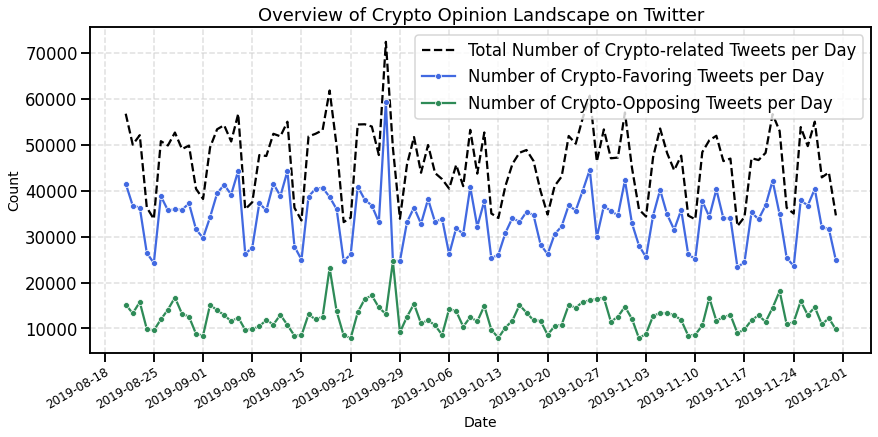

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))


sns.lineplot(x='date', y='total_btc_count',
              data=ts1[ts1.date>ts1.date.min()],ax=ax,label = 'Total Number of Crypto-related Tweets per Day',
            color = 'black', linestyle = 'dashed')
sns.lineplot(x='date', y='total_btc_favor_count',
              data=ts1[ts1.date>ts1.date.min()],ax=ax,marker='o',markersize =6,label='Number of Crypto-Favoring Tweets per Day',
            color = 'royalblue')
sns.lineplot(x='date', y='total_btc_oppo_count',
              data=ts1[ts1.date>ts1.date.min()],ax=ax,marker='o',markersize =6,label='Number of Crypto-Opposing Tweets per Day',
            color = 'seagreen')
            
ax.set_xlabel('Date',fontsize = 14)
ax.set_ylabel(f"Count",fontsize = 14)
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
plt.setp(ax.get_xticklabels(), fontsize = 12, rotation=30, ha="right", rotation_mode="anchor")
ax.grid(linestyle="--", alpha=0.4)

ax.set_title("Overview of Crypto Opinion Landscape on Twitter", fontsize = 18)
# fig.savefig('/content/drive/MyDrive/Research-1: Sentiment Dynamics toward Crypto and BTC/Graph/Crypto Opinion Polarity/num_tweets.png',dpi=300,bbox_inches= 'tight')
plt.show()


#### 3-2. Sentiment: Sentiment Classification & Sentiment Intensity 

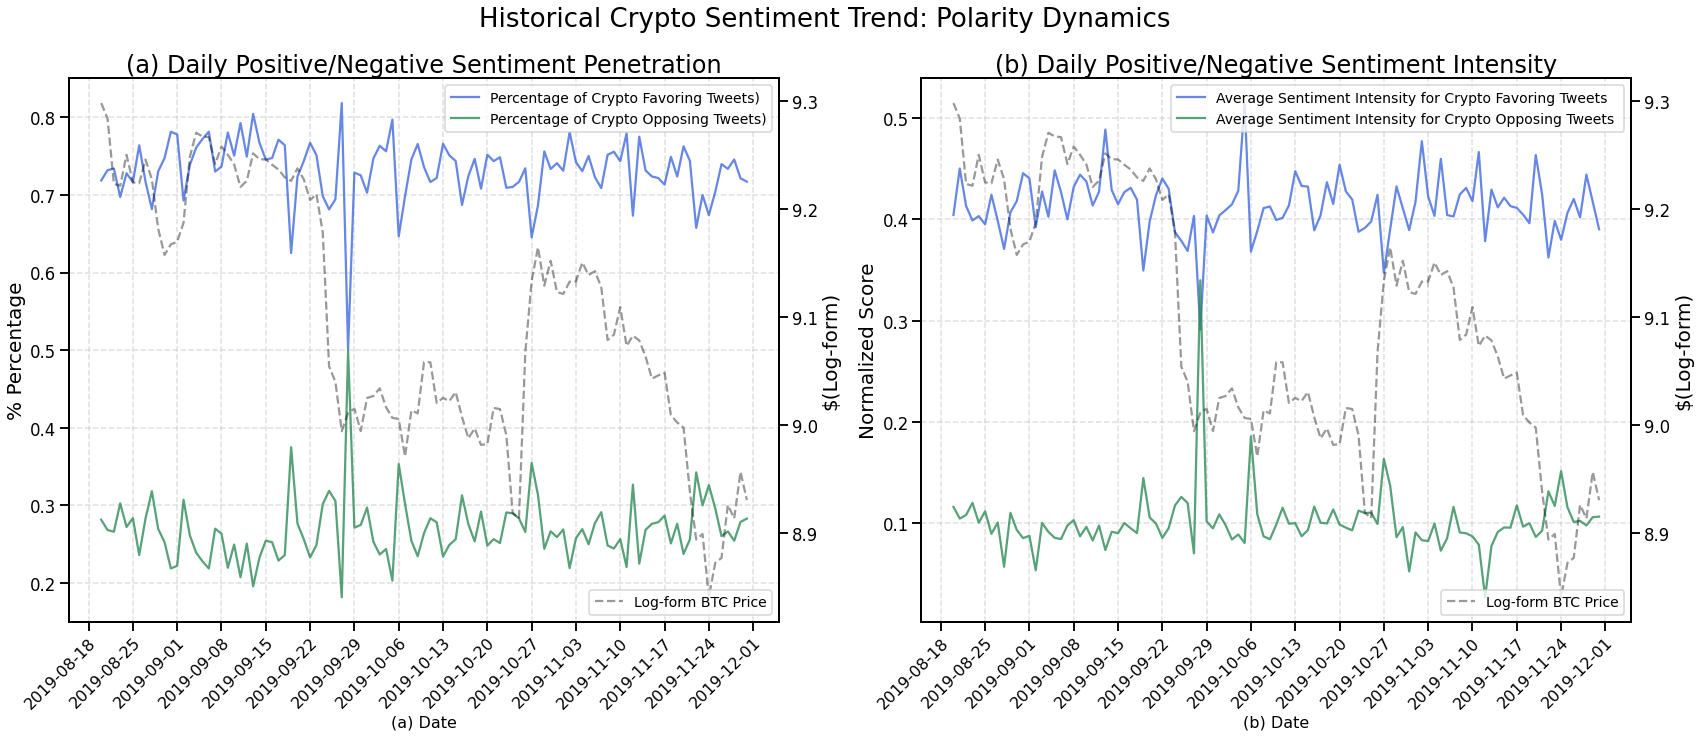

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(28, 10))

sns.lineplot(x='date', y='perc_btc_favor_tweets',
              data=ts1,ax=axes[0],label = 'Percentage of Crypto Favoring Tweets)',# marker='o',markersize= 6,
            color = 'royalblue',alpha = 0.8)
sns.lineplot(x='date', y='perc_btc_oppo_tweets',
              data=ts1,ax=axes[0],label = 'Percentage of Crypto Opposing Tweets)',# marker='o',markersize= 6,
            color = 'seagreen',alpha = 0.8)
axes[0].set_title(f"(a) Daily Positive/Negative Sentiment Penetration",fontsize=24)
axes[0].set_xlabel('(a) Date',fontsize = 16)
axes[0].set_ylabel(f"% Percentage",fontsize = 20)
axes[0].xaxis.set_major_locator(ticker.MultipleLocator(7))
plt.setp(axes[0].get_xticklabels(), fontsize = 16, rotation=45, ha="right", rotation_mode="anchor")
axes[0].legend(loc=0,fontsize=14)
axes[0].grid(linestyle="--", alpha=0.4)
ax0_y = axes[0].twinx()
sns.lineplot(x='date', y='log_avg_price', 
              data=price[price.date.between(ts1.date.min(),ts1.date.max())],ax=ax0_y, label = 'Log-form BTC Price',
            color = 'black',alpha = 0.4,linestyle = 'dashed',# marker='o',markersize= 6,
)
ax0_y.xaxis.set_major_locator(ticker.MultipleLocator(7))
plt.setp(ax0_y.get_xticklabels(), fontsize = 16, rotation=45, ha="right", rotation_mode="anchor")
ax0_y.set_ylabel(f"$(Log-form)",fontsize = 20)
ax0_y.legend(loc=4,fontsize = 14)
axes[0].tick_params(top=False)

sns.lineplot(x='date', y='avg_btc_favor_scores',
              data=ts1,ax=axes[1],label = 'Average Sentiment Intensity for Crypto Favoring Tweets ',# marker='o',markersize= 6,
            color = 'royalblue',alpha = 0.8)
sns.lineplot(x='date', y='avg_btc_oppo_scores',
              data=ts1,ax=axes[1],label = 'Average Sentiment Intensity for Crypto Opposing Tweets ',# marker='o',markersize= 6,
            color = 'seagreen',alpha = 0.8)
axes[1].set_title(f"(b) Daily Positive/Negative Sentiment Intensity",fontsize=24)
axes[1].set_xlabel('(b) Date',fontsize = 16)
axes[1].set_ylabel(f"Normalized Score",fontsize = 20)
axes[1].xaxis.set_major_locator(ticker.MultipleLocator(7))
plt.setp(axes[1].get_xticklabels(), fontsize = 16, rotation=45, ha="right", rotation_mode="anchor")
axes[1].legend(loc=1,fontsize = 14)
axes[1].grid(linestyle="--", alpha=0.4)
ax1_y = axes[1].twinx()
sns.lineplot(x='date', y='log_avg_price', 
              data=price[price.date.between(ts1.date.min(),ts1.date.max())], ax=ax1_y, label = 'Log-form BTC Price',
            color = 'black',alpha = 0.4,linestyle = 'dashed',# marker='o',markersize= 6,
)
ax1_y.xaxis.set_major_locator(ticker.MultipleLocator(7))
plt.setp(ax1_y.get_xticklabels(), fontsize = 16, rotation=45, ha="right", rotation_mode="anchor")
ax1_y.set_ylabel(f"$(Log-form)",fontsize = 20)
ax1_y.legend(loc=4,fontsize = 14)
axes[1].tick_params(top=False)

fig.suptitle("Historical Crypto Sentiment Trend: Polarity Dynamics", fontsize = 26)
plt.savefig('/content/drive/MyDrive/Research-1: Sentiment Dynamics toward Crypto and BTC/Graph/Crypto Opinion Polarity/eda_btc_lineplot_2.png',dpi=300)
plt.show()


In [ ]:
from scipy.stats.stats import pearsonr
pearsonr(ts1.avg_btc_favor_scores,ts1.avg_btc_oppo_scores)

(-0.5873005885892639, 6.997880888512628e-11)

# Content Analysis
- Now that we know the sentiments, what about the tweet text content? 
- What do people usually say about cryptocurrency?
- Are positive tweets likely to contain different words from the negative tweets?

## Representing Tweeets using TF-DF
- Tensorflow Projector: PCA & t-SNE
- TF-IDF(Reference):*italicized text* https://towardsdatascience.com/natural-language-processing-feature-engineering-using-tf-idf-e8b9d00e7e76

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [ ]:
# Word embedding using TF-IDF
tw_project_df = df.sample(10000,random_state = 123)
tw_project_df.heavy_clean_text = list(map(heavy_preprocessing_for_topic, tw_project_df.clean_text))

tw_tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words = 'english')
tw_vectors = tw_tfidf_vectorizer.fit_transform([i for i in tw_project_df.heavy_clean_text])
tw_feature_names = tw_tfidf_vectorizer.get_feature_names()

tw_tfidf_df = pd.DataFrame(tw_vectors.todense().tolist(), columns=tw_feature_names)
tw_tfidf_df['sentiment_class'] = list(tw_project_df.final_sentiment_class)
tw_tfidf_df = tw_tfidf_df[['sentiment_class']+tw_feature_names]

tw_tfidf_df.head()

,sentiment_class,ability,able,absolutely,accept,accepting,accepts,access,account,act,...,xvg,yeah,year,yes,yesterday,youtube,zec,zero,zone,zrx
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
tw_out_v = io.open('/content/drive/MyDrive/Research: Changing Opinions towards Cryptocurrency under Rising Cost of Living/Data/Crypto Tweets-Twitter API/tw_tfidf_vectors.tsv', 'w', encoding='utf-8')
tw_out_m = io.open('/content/drive/MyDrive/Research: Changing Opinions towards Cryptocurrency under Rising Cost of Living/Data/Crypto Tweets-Twitter API/tw_metadata.tsv', 'w', encoding='utf-8')

for i in range(len(tw_tfidf_df)): 
  # index, word in enumerate(vocab):
  if i == 0:
    # tw_out_m.write('\t'.join(['sentiment_class']) + "\n")
    continue  # skip 0, it's padding.
  tw_vec = tw_tfidf_df.loc[i,tw_feature_names]
  tw_meta = tw_tfidf_df.loc[i,['sentiment_class']]
  tw_out_v.write('\t'.join([str(x) for x in tw_vec]) + "\n")
  tw_out_m.write('\t'.join([str(x) for x in tw_meta]) + "\n")
tw_out_v.close()
tw_out_m.close()

In [ ]:
try:
  from google.colab import files
  files.download('/content/drive/MyDrive/Research: Changing Opinions towards Cryptocurrency under Rising Cost of Living/Data/Crypto Tweets-Twitter API/tw_tfidf_vectors.tsv')
  files.download('/content/drive/MyDrive/Research: Changing Opinions towards Cryptocurrency under Rising Cost of Living/Data/Crypto Tweets-Twitter API/tw_metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Topic Modeling

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
lemmatizer = WordNetLemmatizer()

def heavy_preprocessing_for_topic(s,lemmatizer=lemmatizer):
    """
    This heavy preprocessing function serves the specific purpose for topic modeling, rather than sentiment analysis
    """
    s = s.lower()
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Remove hashtags
    s = re.sub("#\S+", " ", s)
    # Remove ticks and the next character
    s = re.sub("\'\w+", '', s)        
    # Isolate and remove punctuations (synonymous to string.punctuation)
    s = re.sub(r'[^\w\s]|\_', ' ', s) 
    # Remove numbers
    s = re.sub(r'\w*\d+\w*', '', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopword or non-English word
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english') and word.encode().isalpha()])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    # Lemmatization
    s = ' '.join([lemmatizer.lemmatize(word) for word in s.split()])
    return s

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
ht_nodes_raw['hashtags'] = list(map(lambda x:combine_dict[x],ht_nodes_raw.hashtags))
ht_doc = ht_nodes_raw.groupby(['hashtags']).agg(
    all_tweets = pd.NamedAgg(column = 'clean_text', aggfunc = lambda x: '|'.join(x)),
    perc_btc_favor_tweets = pd.NamedAgg(column = 'is_btc_favor_tweets',aggfunc= lambda x: np.average(x, weights=ht_nodes_raw.loc[x.index, "rt_total_cnt"])
)
).reset_index()
ht_doc['sentiment_label'] = list(map(lambda x:round(x,0), ht_doc.perc_btc_favor_tweets))
ht_doc.head(3)

,hashtags,all_tweets,perc_btc_favor_tweets,sentiment_label
0,"#""atlantis","#ethereum #classic #""atlantis"" #upgrade makes etc more like #eth #instaico #instaethereum #cryptocurrency #ico #monero #newcryptocurrency #bittrex #fintech $CNY $QRL $BTCUSD #rt",1.0,1.0
1,"#""bitcoin","#""bitcoin will never hit #50k"" says #crypto #skeptic #peter #schiff #instaethereum #instaeth #instaairdrop #btcnews #xrp #altcoins #binance #SmartContracts #SmartCash #cryptonews #IoT $CNY",0.0,0.0
2,"#""coding","#""coding a first #amendment #right"": the #electronic #frontier #foundation #defends #etherdelta #cryptocurrency #binance #cryptonews #ltc #virtualcurrency #investing #buyorders #FUD #hardfork #fomo #publickey #proofofstake",0.0,0.0


In [ ]:
# Filtering out those weird hashtags, according to ht_nodes
print("Before filtering by nodes: number of hastags: ", ht_doc.shape[0])
ht_doc = pd.merge(left = ht_doc, right = ht_nodes_clean[['hashtags']], how = 'inner', on = 'hashtags') 
print("After filtering by nodes: number of hastags: ", ht_doc.shape[0])


Before filtering by nodes: number of hastags:  116942
After filtering by nodes: number of hastags:  53053


In [ ]:
# 1min for 10,000 tweet
%time ht_doc.loc[:,'all_tweets_heavy_proc'] = list(map(heavy_preprocessing_for_topic, ht_doc.loc[:,'all_tweets']))

CPU times: user 3h 17min 40s, sys: 22min 19s, total: 3h 39min 59s
Wall time: 3h 39min 52s


In [ ]:
hf.view(ht_doc)

The dataset consists of 53053 rows and 5 columns
The columns are: ['hashtags', 'all_tweets', 'perc_btc_favor_tweets', 'sentiment_label', 'all_tweets_heavy_proc']


,hashtags,all_tweets,perc_btc_favor_tweets,sentiment_label,all_tweets_heavy_proc
data_types,object,object,float64,float64,object
value_counts,51201,48873,5218,2,48596
null_counts,0,0,0,0,0
0,###what,#####What is the best Bitcoin Binance trading BOT for Cryptocurrency? – Crypto Classifieds|#####What is the best Bitcoin Binance trading BOT for Cryptocurrency? – Crypto Classifieds,1.0,1.0,best bitcoin binance trading bot cryptocurrency crypto classified best bitcoin binance trading bot cryptocurrency crypto classified
1,##9,"GOSPEL SEED NOW! ###9 Oct 31, 2019 02:58 PM, EDT Bitcoin (BTC, bitcoins) 0.029337 BTC 7% daily (201-500$) + depo back 6 из 10000 0.009037 BTC 07:01:25 Active ^|GOSPEL SEED NOW! ###9 Oct 31, 2019 02:58 PM, EDT Bitcoin (BTC, bitcoins) 0.029337 BTC 7% daily (201-500$) + depo back 6 из 10000 0.00903...",1.0,1.0,gospel seed oct pm edt bitcoin btc bitcoins btc daily depo back btc active gospel seed oct pm edt bitcoin btc bitcoins btc daily depo back btc active
2,##advanced,###Advanced Bitcoin Crypto Trading Bots On Telegram Bitcoin Binance Mobile APP & Crypto Signals on Telegram|###Advanced Bitcoin Crypto Trading Bots On Telegram Bitcoin Binance Mobile APP & Crypto Signals on Telegram|###Advanced Bitcoin Crypto Trading Bots On Telegram Bitcoin Binance Mobile APP &...,1.0,1.0,bitcoin crypto trading bot telegram bitcoin binance mobile app crypto signal telegram bitcoin crypto trading bot telegram bitcoin binance mobile app crypto signal telegram bitcoin crypto trading bot telegram bitcoin binance mobile app crypto signal telegram



##### Count Vectorizer
  You should use CountVectorizer when fitting LDA instead of TfidfVectorizer 
  since LDA is based on term count and document count. 
  Fitting LDA with TfidfVectorizer will result in rare words being dis-proportionally sampled. 
  As a result, they will have greater impact and influence on the final topic distribution.

  Ref: https://towardsdatascience.com/introduction-to-topic-modeling-using-scikit-learn-4c3f3290f5b9

In [ ]:
ht_doc = pd.read_csv("/content/drive/MyDrive/Research-1: Sentiment Dynamics toward Crypto and BTC/Data/Crypto Tweets-Twitter API/ht_doc_clean.csv",index_col = 0)
ht_doc = ht_doc.dropna(subset = ['all_tweets_heavy_proc'])

In [ ]:
ht_doc.head(3)

,hashtags,all_tweets,perc_btc_favor_tweets,sentiment_label,all_tweets_heavy_proc,topic_words
0,#!/usr/bin/env,"#!/usr/bin/env python # -*- coding: utf-8 -*- import python_bitbankcc import json p = python_bitbankcc.private('k', 's') def buy(): v = p.order('btc_jpy', '777', 0.001, 'buy', 'market') print(json.dumps(v)) def main(): print('積立 #Bitcoin $BTC') buy() main()",0.0,0.0,python coding utf import python bitbankcc import json p python bitbankcc private def buy v p order print json dump v def main print btc buy main,bitcoin|crypto|time|market|average|exchange|trading|buy|news|like|day|free|blockchain|money|people|coin|current|btc average|make
1,"#""atlantis","#ethereum #classic #""atlantis"" #upgrade makes etc more like #eth #instaico #instaethereum #cryptocurrency #ico #monero #newcryptocurrency #bittrex #fintech $CNY $QRL $BTCUSD #rt",1.0,1.0,make etc like cny qrl btcusd,btc|price|eth|usd|xrp|ltc|btc eth|bitcoin|btc usd|bch|volume alert|change|eos|currently|volume|eth xrp|jpy|volume btc|ripple
2,"#""bitcoin","#""bitcoin will never hit #50k"" says #crypto #skeptic #peter #schiff #instaethereum #instaeth #instaairdrop #btcnews #xrp #altcoins #binance #SmartContracts #SmartCash #cryptonews #IoT $CNY",0.0,0.0,never hit say cny,btc|price|eth|usd|xrp|ltc|btc eth|bitcoin|btc usd|bch|volume alert|change|eos|currently|volume|eth xrp|jpy|volume btc|ripple


In [ ]:
# ~4 min for full dataset
from sklearn.feature_extraction.text import CountVectorizer

# Count Vectorizer for all tweets
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english', ngram_range=(1, 2))
tf_vectors = tf_vectorizer.fit_transform([i for i in ht_doc['all_tweets_heavy_proc']])
tf_feature_names = tf_vectorizer.get_feature_names()

# Count Vectorizer for positive tweets
tf_vectorizer_p = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english', ngram_range=(1, 2))
tf_vectors_p = tf_vectorizer_p.fit_transform([i for i in ht_doc.loc[ht_doc.sentiment_label == 1, 'all_tweets_heavy_proc']])
tf_feature_names_p = tf_vectorizer_p.get_feature_names()

# Count Vectorizer for negative tweets
tf_vectorizer_n = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english', ngram_range=(1, 2))
tf_vectors_n = tf_vectorizer_n.fit_transform([i for i in ht_doc.loc[ht_doc.sentiment_label == 0, 'all_tweets_heavy_proc']])
tf_feature_names_n = tf_vectorizer_n.get_feature_names()

##### Topic Modeling
Reference 1: https://www.analyticsvidhya.com/blog/2021/06/part-3-topic-modeling-and-latent-dirichlet-allocation-lda-using-gensim-and-sklearn/       
Reference 2: https://www.analyticsvidhya.com/blog/2021/07/topic-modelling-with-lda-a-hands-on-introduction/

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

def fit_lda_model(n_components, vectors):
  '''
  You should use CountVectorizer when fitting LDA instead of TfidfVectorizer 
  since LDA is based on term count and document count. 
  Fitting LDA with TfidfVectorizer will result in rare words being dis-proportionally sampled. 
  As a result, they will have greater impact and influence on the final topic distribution.

  Ref: https://towardsdatascience.com/introduction-to-topic-modeling-using-scikit-learn-4c3f3290f5b9
  '''
  lda_model=LatentDirichletAllocation(
      n_components=n_components, # number of topics
      learning_method='online',
      random_state=42,
      max_iter=3).fit(vectors)  
  return lda_model

def get_topic_and_words(n_top_words, lda_model, feature_names):
  # Retrieve the topics
  topic_words_dict = dict()

  # print("All the 10 topics for the BTC-relevant tweets on Twitter\n---------------------------------------------------------------")
  for i, topic_dist in enumerate(lda_model.components_):
    sorted_topic_dist = np.argsort(topic_dist)

    topic_words = np.array(tf_feature_names)[sorted_topic_dist]
    topic_words = topic_words[:-n_top_words:-1]
    topic_words_dict[i] = list(topic_words)  
  
  return topic_words_dict

In [ ]:
from sklearn.model_selection import GridSearchCV
gridcv = GridSearchCV(
    cv = 3,
    estimator = lda_model_all, 
    param_grid= {'n_components': [1,2,3,4,5,6,7,8,9,10]}
)
gridcv.fit(tf_vectors)

# Best Model
best_lda_model = gridcv.best_estimator_
# Model Parameters
print("Best Model's Params: ", gridcv.best_params_)
# Log Likelihood Score
print("Best Log Likelihood Score: ", gridcv.best_score_)
# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(tf_vectors))

Best Model's Params:  {'n_components': 9}
Best Log Likelihood Score:  -101677291.89578782
Model Perplexity:  407.7949919305359


How to interpret the plLDAvis:    
Reference: 
- https://towardsdatascience.com/topic-model-visualization-using-pyldavis-fecd7c18fbf6
- https://neptune.ai/blog/pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know



In [ ]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=b28c981e320abdaeb8fd2936e4aedbf076de865d3a09102322a7e02a6182eeed
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [ ]:
# lda_model_pos = fit_lda_model(4,tf_vectors_p)
# lda_model_neg = fit_lda_model(4,tf_vectors_n)
lda_model_all = fit_lda_model(4,tf_vectors)

In [ ]:
import pyLDAvis.sklearn
def pyLDAvis_display(lda_model, sentiment_category = 'positive'):
  pyLDAvis.enable_notebook()
  if sentiment_category == 'positive':
    vis = pyLDAvis.sklearn.prepare(lda_model, tf_vectors_p, tf_vectorizer_p)
    return vis
  elif sentiment_category == 'negative':
    vis = pyLDAvis.sklearn.prepare(lda_model, tf_vectors_n, tf_vectorizer_n)
    return vis
  elif sentiment_category == 'all':
    vis = pyLDAvis.sklearn.prepare(lda_model, tf_vectors, tf_vectorizer)
    return vis

In [ ]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(lda_model_3, tf_vectors, tf_vectorizer)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.103391 -0.278709       1        1  68.163593
0     -0.255163  0.209785       2        1  24.046779
1      0.358554  0.068924       3        1   7.789628, topic_info=         Term          Freq         Total Category  logprob  loglift
116       btc  3.247246e+06  3.247246e+06  Default  30.0000  30.0000
660     price  1.242910e+06  1.242910e+06  Default  29.0000  29.0000
306       eth  9.103530e+05  9.103530e+05  Default  28.0000  28.0000
918       usd  6.288000e+05  6.288000e+05  Default  27.0000  27.0000
225    crypto  1.998588e+06  1.998588e+06  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
198   company  5.719780e+04  1.451579e+05   Topic3  -4.4831   1.6211
142       buy  6.116231e+04  3.488989e+05   Topic3  -4.4161   0.8111
144  buy sell  5.166774e+04  8.289414e+04   Topic3  -4.5848   2.0796
765      sell  5.402953e+04  2.508613e+05   Topic3  -4.5401   1.0170
993      year  5.332611e+04  2.323908e+05   Topic3  -4.5532   1.0804

[237 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
9         1  0.015752         ada
9         2  0.984243         ada
10        1  0.000089     ada xrp
10        2  0.999897     ada xrp
21        1  0.037131       alert
...     ...       ...         ...
993       1  0.770530        year
993       3  0.229467        year
994       3  0.999998  year human
997       1  0.012923         zec
997       2  0.987047         zec

[363 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

## Word Frequency

##### Word Cloud

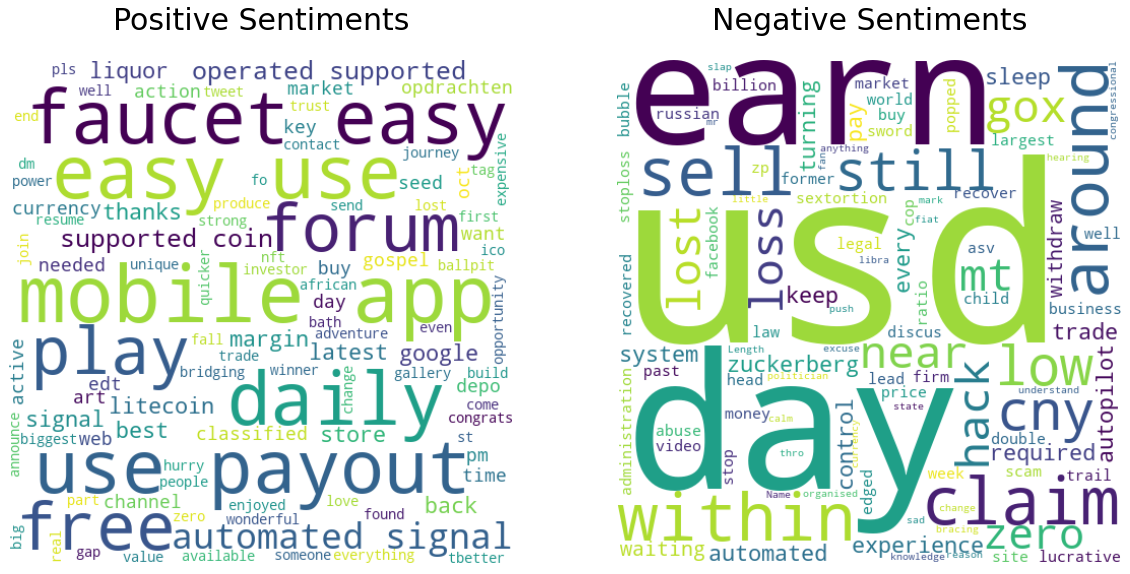

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Remove those weird ht_nodes
tmp = pd.merge(left = ht_doc, right = ht_nodes_clean[['hashtags']], how = 'inner', on = 'hashtags') 
f = plt.figure(figsize = (20,20))

f.add_subplot(1, 2, 1)
# Create a WordCloud object
wordcloud1 = WordCloud(stopwords=STOPWORDS, background_color="white", max_words=100, random_state = 123, width=500, height=500, contour_color='steelblue')
# Generate a word cloud
s = re.sub("crypto|bitcoin|eth|etc|btc|ltc|eur|zum|bittrex|steemit|qrl|telegram|binance|bitmex|trading|bot|installed|machine|september|jpy|xbt|alert","",str(tmp.loc[tmp.perc_btc_favor_tweets >= 0.7,'all_tweets_heavy_proc']))
wordcloud1.generate(s)
# Visualize the word cloud
plt.imshow(wordcloud1, interpolation='bilinear')
plt.title('Positive Sentiments', size=30, pad = 30)
plt.axis("off")

f.add_subplot(1, 2, 2)
# Create a WordCloud object
wordcloud2 = WordCloud(stopwords=STOPWORDS, background_color="white", max_words=100, random_state = 123, width=500, height=500, contour_color='steelblue')
# Generate a word cloud
s = re.sub("crypto|bitcoin|eth|etc|btc|ltc|eur|zum|bittrex|steemit|qrl|telegram|binance|bitmex|trading|bot|installed|machine|all_tweets_heavy_proc|dtypes|september|jpy|xbt|alert","",str(tmp.loc[tmp.perc_btc_favor_tweets < 0.3,'all_tweets_heavy_proc']))
wordcloud2.generate(s)
# Visualize the word cloud
plt.imshow(wordcloud2, interpolation='bilinear')
plt.title('Negative Sentiments', size=30, pad = 30)
plt.axis("off")
# plt.savefig('/content/drive/MyDrive/Research: Changing Opinions towards Cryptocurrency under Rising Cost of Living/Graph/Crypto Opinion Polarity/wordcloud_recovered_stoploss.png',dpi=300)
plt.show()

# Hashtag Co-occurrence Network Analysis
I construct a co-occurrence network graph wit **a each node and edge representing a hashtag and whether two hashtags appear on the same tweet, respectively**. The **size of the node** reflects the **number of tweets** associated with the hashtag, which describes the magnitude of influence. The distribution of hashtags clusters provides important insights from the perspective of social network structure.

In [ ]:
pd.set_option('max_colwidth',300)

# Read in the processed file (thanks to midway)
ht_nodes_clean = pd.read_csv("/content/drive/MyDrive/Research-1: Sentiment Dynamics toward Crypto and BTC/Data/Crypto Tweets-Twitter API/ht_nodes_clean.csv",index_col = 0)
ht_edges_clean = pd.read_csv("/content/drive/MyDrive/Research-1: Sentiment Dynamics toward Crypto and BTC/Data/Crypto Tweets-Twitter API/ht_edges_clean.csv",index_col = 0)
combine_df = pd.read_csv("/content/drive/MyDrive/Research-1: Sentiment Dynamics toward Crypto and BTC/Data/Crypto Tweets-Twitter API/combine_df.csv",index_col = 0)

In [ ]:
# Further clean the edge
combine_dict = dict(zip(combine_df.old_ht,combine_df.new_ht)) 
ht_edges_clean['edge_node1'] = list(map(lambda x:combine_dict[x], ht_edges_clean.edge_node1))
ht_edges_clean['edge_node2'] = list(map(lambda x:combine_dict[x], ht_edges_clean.edge_node2))

In [ ]:
# Further clean the nodes
ht_nodes_clean = ht_nodes_clean[ht_nodes_clean.num_tweets > 1].reset_index(drop=True)

In [ ]:
ht_nodes_clean = ht_nodes_clean.groupby(['hashtags']).agg({
    'num_tweets':'sum',
    'perc_btc_favor_tweets':'mean',
    'perc_btc_oppo_tweets':'mean',
    'favor_oppo_diff':'mean'
}).reset_index()

In [ ]:
ht_nodes_clean.head()

,hashtags,num_tweets,perc_btc_favor_tweets,perc_btc_oppo_tweets,favor_oppo_diff
0,###what,2,1.0,0.0,1.0
1,##9,2,1.0,0.0,1.0
2,##advanced,3,1.0,0.0,1.0
3,##best,55,1.0,0.0,1.0
4,##binance,9,1.0,0.0,1.0


### Node: Hashtag

##### **Retrieve Hashtags**
It seems we can directly query 'hashtag' from each tweet from the response： https://stackoverflow.com/questions/25895321/how-to-extract-hashtags-from-tweepy-using-tweepy-cursor-and-api-*search* 

In [ ]:
import string

def get_hashtags(tweet):
  tweet = ''.join(filter(lambda x: x in string.printable,tweet))
  tweet = tweet.replace("##"or"###"or"####","#")
  return [x.rstrip(' '+string.punctuation).lower() for x in tweet.split(' ') if (x.startswith('#') and x.rstrip(' '+string.punctuation)!= '# ' and not(x.rstrip(' '+string.punctuation)[1:].isdigit()))]

In [ ]:
df['hashtags'] = list(map(get_hashtags, df.clean_text))
df['hashtags_num'] = list(map(len,df.hashtags))
df['has_hashtags']=list(map(lambda x:1 if x>0 else 0, df.hashtags_num))

#### Preprocessing

In [ ]:
ht_nodes_raw = df.explode('hashtags').reset_index(drop=True)
ht_nodes_raw = ht_nodes_raw.drop_duplicates(subset = ['hashtags','clean_text','create_ts','tweet_id'])
ht_nodes_raw = ht_nodes_raw[ht_nodes_raw.hashtags !='']
ht_nodes_raw.hashtags.fillna('No_Hashtag',inplace =True)

In [ ]:
def add_metrics(df, groupby_col):
    tmp_df = df.groupby(groupby_col).agg(
        num_tweets = pd.NamedAgg(column = 'is_btc_favor_tweets',aggfunc='count'),  
        perc_btc_favor_tweets = pd.NamedAgg(column = 'is_btc_favor_tweets',aggfunc=lambda x: np.average(x, weights=df.loc[x.index, "rt_total_cnt"])),
        perc_btc_oppo_tweets = pd.NamedAgg(column = 'is_btc_oppo_tweets',aggfunc=lambda x: np.average(x, weights=df.loc[x.index, "rt_total_cnt"])),
    ).reset_index()

    tmp_df['favor_oppo_diff']= tmp_df.perc_btc_favor_tweets - tmp_df.perc_btc_oppo_tweets
    return tmp_df

ht_nodes = add_metrics(ht_nodes_raw,'hashtags')
# ht_nodes['favor_oppo_diff']= ht_nodes.perc_btc_favor_tweets - ht_nodes.perc_btc_oppo_tweets
ht_nodes['favor_oppo_diff'].describe()

count    955.000000
mean       0.441275
std        0.834600
min       -1.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: favor_oppo_diff, dtype: float64

In [ ]:
# Add on 05/28
# removing hashtags with just 1 tweet
ht_nodes = ht_nodes[ht_nodes.num_tweets>1]

# Map to the clean node dictionary (preprocessed using similar string difflib)
ht_nodes.hashtags = list(map(lambda x:combine_dict[x], ht_nodes.hashtags))

In [ ]:
import difflib

def combine_similar_hashtags(ht_nodes,combine_df):
    
  try:
    for i in range(len(ht_nodes)):
      ht_nodes.loc[i,'sim_score_next_ht'] = difflib.SequenceMatcher(None, ht_nodes.hashtags[i],ht_nodes.hashtags[i+1]).quick_ratio()
      ht_nodes.loc[i,'sim_ht']=ht_nodes.loc[i+1,'hashtags']
  except:
    ht_nodes.loc[i,'sim_score_next_ht'] = 0
    ht_nodes.loc[i,'sim_ht']='No_Hashtag'

  combine_df = pd.concat([combine_df,ht_nodes.loc[ht_nodes.sim_score_next_ht>=0.9,['hashtags','sim_ht']]],axis = 0)
  ht_nodes['hashtags'] = list(map(lambda a,x,y:y if a>=0.9 else x, ht_nodes['sim_score_next_ht'],ht_nodes['hashtags'],ht_nodes['sim_ht']))
  ht_nodes['original_hashtags'] = ht_nodes.hashtags

  num_changed = len(ht_nodes[ht_nodes.sim_score_next_ht>=0.9])

  print("Number of hashtags changed: ",num_changed)

  # aggregate those similar nodes
  ht_nodes = ht_nodes.groupby(['hashtags']).agg(
        num_tweets = pd.NamedAgg(column = 'num_tweets',aggfunc='sum'), 
        perc_btc_favor_tweets = pd.NamedAgg(column = 'perc_btc_favor_tweets',aggfunc='mean'),
        perc_btc_oppo_tweets = pd.NamedAgg(column = 'perc_btc_oppo_tweets',aggfunc='mean'),
        var_perc_btc_favor_tweets = pd.NamedAgg(column = 'var_perc_btc_favor_tweets',aggfunc='mean'),
        favor_oppo_diff = pd.NamedAgg(column = 'favor_oppo_diff',aggfunc='mean')
    ).reset_index()
  
  return ht_nodes,combine_df

In [ ]:
combine_df = pd.DataFrame()

for i in range(3):
  ht_nodes,combine_df = combine_similar_hashtags(ht_nodes,combine_df)

combine_df.columns = ['old_ht','new_ht']
combine_df = pd.concat([combine_df.reset_index(drop=True),pd.DataFrame({'old_ht':ht_nodes.hashtags,'new_ht':ht_nodes.hashtags})],axis = 0)
combine_df = combine_df.drop_duplicates()
combine_dict = dict(zip(combine_df.old_ht,combine_df.new_ht)) 

Number of hashtags changed:  10124
Number of hashtags changed:  1564
Number of hashtags changed:  414


In [ ]:
ht_nodes = ht_nodes.sort_values(by='num_tweets',ascending = False)
hf.view(ht_nodes)

The dataset consists of 149630 rows and 6 columns
The columns are: ['hashtags', 'num_tweets', 'perc_btc_favor_tweets', 'perc_btc_oppo_tweets', 'var_perc_btc_favor_tweets', 'favor_oppo_diff']


,hashtags,num_tweets,perc_btc_favor_tweets,perc_btc_oppo_tweets,var_perc_btc_favor_tweets,favor_oppo_diff
data_types,object,int64,float64,float64,float64,float64
value_counts,149630,1543,5475,5467,8144,5777
null_counts,0,0,0,0,83853,0
149629,No_Hashtag,2111954,0.430102,0.569898,0.245114,-0.139797
19496,#bitcoin,777660,0.466824,0.533176,0.2489,-0.066353
39201,#crypto,603292,0.246999,0.753001,0.249964,-0.506003


### Edge: Hashtag Co-occurence

#### Preprocessing

In [ ]:
import itertools
def get_hashtag_pairs(hashtag_lst):
    return list(itertools.combinations(hashtag_lst, 2))

# we consider those tweets who has more than 1 hashtags, for the purpose of creating a co-occurence network  
ht_edges_raw = df[df.hashtags_num>1].copy()
ht_edges_raw['hashtag_edges'] = list(map(get_hashtag_pairs,ht_edges_raw.hashtags))
ht_edges_raw = ht_edges_raw.explode('hashtag_edges').reset_index(drop=True)
ht_edges_raw = ht_edges_raw.drop_duplicates(subset=['hashtag_edges','clean_text','create_ts','tweet_id'])

def get_nodes_from_tuple(x,index,combine_dict=combine_dict):
  try:
    return combine_dict[tuple(x)[index]]
  except:
    return tuple(x)[index]

ht_edges_raw['edge_node1'] = list(map(lambda x:get_nodes_from_tuple(x,0), ht_edges_raw.hashtag_edges))
ht_edges_raw['edge_node2'] = list(map(lambda x:get_nodes_from_tuple(x,1), ht_edges_raw.hashtag_edges))

# drop those null hashtags
ht_edges_raw = ht_edges_raw[(ht_edges_raw.edge_node1 != '') & (ht_edges_raw.edge_node1 != '')]

In [ ]:
ht_edges = add_metrics(ht_edges_raw,['hashtag_edges','edge_node1','edge_node2'])

In [ ]:
hf.view(ht_edges)

#### Cleaning
- drop hashtag pairs that don't make sense
  1. hashtag_node != '#'/'##'
  2. self-loop hashtag_edges
  3. pure number hashtags
- drop hashtag pairs that have low statistical significance (p-value)
> Disentangling categorical relationships through a graph of co-occurrences, PHYSICAL REVIEW E 84, 046108 (2011)


In [ ]:
print("before cleaning: ",len(ht_edges),' rows')
ht_edges = ht_edges[(~ht_edges.edge_node1.isin(['#','#"','#!','##','#|']+["#"+i for i in string.digits]))&(~ht_edges.edge_node2.isin(['#','#"','#!','##','#|']+["#"+i for i in string.digits]))]
ht_edges = ht_edges[ht_edges.num_tweets > 1]
ht_edges = ht_edges[ht_edges.edge_node1!=ht_edges.edge_node2]
ht_edges = ht_edges[(ht_edges.edge_node1.isin(list(ht_nodes.hashtags)))&(ht_edges.edge_node2.isin(list(ht_nodes.hashtags)))]
ht_edges = ht_edges.reset_index(drop = True)
print("after cleaning: ",len(ht_edges),' rows')

before cleaning:  762130  rows
after cleaning:  762130  rows


In [ ]:
from numba import jit
p_k = np.array([])

@jit(nopython=True)
def get_co_occur_pval(n1,n2,k,p_k = np.array([]),N=len(df)):
  """
  n2 = the number of tweets that contain node 2
  k = the number of tweets that contain both node 1 and node 2
  N = total number of tweets
  """
  
  p = 1
  for i in range(k,min(n1,n2)+1):
    for j in range(0,n2-k):
      p *= (1-n1/(N-j))

    for j in range(0,k):
      p *= ((n1-j)*(n2-j))/((N-n2+k-j)*(k-j))
    p_k = np.append(p_k,p)

  return np.sum(p_k)

    

In [ ]:
ht_edges['n1'] = list(map(lambda node:int(ht_nodes.loc[ht_nodes.hashtags == node,'num_tweets'].values), ht_edges.edge_node1))
ht_edges['n2'] = list(map(lambda node:int(ht_nodes.loc[ht_nodes.hashtags == node,'num_tweets'].values), ht_edges.edge_node2))
%time ht_edges.loc[:,'co_occur_pval'] = list(map(get_co_occur_pval,ht_edges.loc[:,'n1'],ht_edges.loc[:,'n2'],ht_edges.loc[:,'num_tweets']))

In [ ]:
ht_edges.co_occur_pval.describe()

In [ ]:
print("Before statistical significance filtering: ",len(ht_edges),' hashtag pairs/edges')
ht_edges_clean = ht_edges.loc[ht_edges.co_occur_pval<=0.00005,['hashtag_edges','edge_node1','edge_node2','num_tweets','co_occur_pval']].reset_index(drop =True)
print("After statistical significance filtering: ",len(ht_edges_clean),' hashtag pairs/edges')


### Graph
- each node represents a hashtag. Size reflects the number of tweets / sentiment intensity
- each edge represents a co-occurrence of the two hashtags. / edge reflects number of co-occurences (to-do)

#### Build the Co-occurence Network Graph 

In [ ]:
g = nx.Graph()
g.add_edges_from(list(map(lambda x,y:(x,y), ht_edges_clean.edge_node1,ht_edges_clean.edge_node2)))
ht_g_nodes = ht_nodes_clean[ht_nodes_clean.hashtags.isin(list(g.nodes))]

In [ ]:
# Remove those weird edge/nodes in the graph that don't exist in ht_nodes
remove_nodes = []
ht_g_nodes_lst = ht_g_nodes.hashtags
for x in g.nodes:
  if x not in list(ht_g_nodes_lst):
    remove_nodes.append(x)

g.remove_nodes_from(remove_nodes)

#### Community Detection and Partition 

In [ ]:
from networkx.algorithms.community.centrality import girvan_newman
def get_girvan_newman_partitions(graph, k_clusters):
    """
    Params:
      graph.......A networkx Graph
      k_clusters......number of desired clusters
    Returns:
      A list of networkx Graph objects, one per partition.

    """
    # documentation: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.centrality.girvan_newman.html
    outputs = girvan_newman(graph)

    all_partitions = [tuple(sorted(c) for c in communities) for communities in itertools.islice(outputs, k_clusters)]
    components = all_partitions[-2]
    print("Number of communities detected: ",len(components))
    print("Size for each community: ", [len(i) for i in components])
    
    return [list(c) for c in components]

# ----------------------------------------------------------------------------------
from numpy.linalg import eigh
def get_second_eigenvector(graph):
    """
    1. Create the Laplacian matrix.
    2. Obtain its eigenvector matrix using the eigh function.
    3. Return the second column eigenvector 
    Returns:
      a 1d numpy array containing the second eigenvector
    >>> np.round(get_second_eigenvector(example_graph()), 2)
    array([ 0.49,  0.3 ,  0.49, -0.21, -0.36, -0.36, -0.36])
    """
    def degree_matrix(graph):
        degrees = dict(graph.degree()).items() # {node: degree}
        # a list of {node: degree}, sorted by key
        degrees = sorted(degrees, key=lambda x: x[0]) 
        degrees = [d[1] for d in degrees] 
        return np.diag(degrees)    
    def adjacency_matrix(graph):
        return nx.adjacency_matrix(graph, sorted(graph.nodes()))

    laplacian = degree_matrix(graph) - adjacency_matrix(graph) # 1. Create the Laplacian matrix.
    eig_vals, eig_vectors = eigh(laplacian) # 2. Obtain its eigenvector matrix using the eigh function.
    return eig_vectors[:,1] # 3. Return the second column eigenvector 

def get_eigenvector_partitions(graph, threshold):
    """
    Using the get_second_eigenvector function above, partition the graph into
    two components using a splitting threshold of 0. That is, nodes
    whose corresponding value in the second eigenvector is >= 0 are in one cluster,
    and the rest are in the other cluster.
    Returns:
      A list of two networkx Graph objects, one per partition. 
      Sort these in ascending order of partition size.
    >>> graph = example_graph()
    >>> result = partition_by_eigenvector(graph)
    >>> sorted(result[0].nodes())
    ['A', 'B', 'C']
    >>> sorted(result[1].nodes())
    ['D', 'E', 'F', 'G']
    >>> round(norm_cut(result[0].nodes(), result[1].nodes(), graph),  2)
    0.42
    """
    S = []
    T = []

    for i, node in enumerate(graph.nodes()):
        if get_second_eigenvector(graph)[i]>=threshold:
          S.append(node)
        else:
          T.append(node)
    g1 = nx.Graph()
    g1.add_nodes_from(S)
    g2 = nx.Graph()
    g2.add_nodes_from(T)    
    return sorted([g1,g2],key=len)

# ----------------------------------------------------------------------------------
# Fast Newman - Modularity
from networkx.algorithms.community import greedy_modularity_communities
def get_newman_modularity_partitions(graph, resolution=1, n_comm=2):
  components = greedy_modularity_communities(graph, resolution = resolution, n_communities=n_comm)
  print(f"Number of communities detected: {len(components)}")
  print(f"Size for each community: { [len(i) for i in components]}")

  return [list(c) for c in components]

# ----------------------------------------------------------------------------------
def reduce_to_2_communities(clusters, cut_index):
  c1 = sum([i for i in clusters[:cut_index]],[])
  c2 = sum([i for i in clusters[cut_index:]],[])
  print(f"Size for cluster 1: {len(c1)}")
  print(f"Size for cluster 2: {len(c2)}")
  return c1,c2  

In [ ]:
# Newman Modularity
%time clusters = get_newman_modularity_partitions(g)

Number of communities detected: 67
Size for each community: [242, 173, 93, 33, 32, 28, 26, 21, 19, 11, 10, 10, 9, 7, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1]
CPU times: user 1.25 s, sys: 0 ns, total: 1.25 s
Wall time: 1.24 s


In [ ]:
# Reduce them to 2 clusters
cluster1, cluster2 = reduce_to_2_communities(clusters,2)

Size for cluster 1: 415
Size for cluster 2: 439


#### Retrieve the subgraph

In [ ]:
ht_node_sizes = dict()
ht_node_sentiments = dict()

def get_sentiment_positive_tiers(perc_btc_favor_tweets):
  # if (favor_oppo_diff >= -1) & (favor_oppo_diff<-0.5):
  #   return '#deab2c' 
  # elif (favor_oppo_diff >= -0.5) & (favor_oppo_diff<0):
  #   return '#e1c086'
  # elif (favor_oppo_diff >= 0.0) & (favor_oppo_diff<0.5):
  #   return '#c3d355'
  # elif (favor_oppo_diff >= 0.5) & (favor_oppo_diff<=1):
  #   return '#9acd32'   
  if (perc_btc_favor_tweets >= 0) & (perc_btc_favor_tweets<0.25):
    return '#deab2c' 
  elif (perc_btc_favor_tweets >= 0.25) & (perc_btc_favor_tweets<0.5):
    return '#e1c086'
  elif (perc_btc_favor_tweets >= 0.5) & (perc_btc_favor_tweets<0.75):
    return '#c3d355'
  elif (perc_btc_favor_tweets >= 0.75):
    return '#9acd32'     
# ht_nodes['sentiment_positive_tiers'] = list(map(lambda x,y:1 if x>=y else 0, ht_nodes.perc_btc_favor_tweets,ht_nodes.perc_btc_oppo_tweets))
ht_g_nodes['sentiment_positive_tiers'] = list(map(get_sentiment_positive_tiers, ht_g_nodes.perc_btc_favor_tweets))

# Build the node dictionary
for node in g.nodes():
  ht_node_sizes[node] = int(ht_g_nodes.loc[ht_g_nodes.hashtags==node,'num_tweets'].values)
  ht_node_sentiments[node] = list(ht_g_nodes.loc[ht_g_nodes.hashtags==node,'sentiment_positive_tiers'].values)[0]

total_tweets = sum(ht_node_sizes.values())

for node in g.nodes():
  ht_node_sizes[node] = ht_node_sizes[node]/total_tweets

# ht_edge_widths = dict()
# for edge in g.edges():
#   ht_edge_widths[edge] = int(ht_edges_clean.loc[((ht_edges_clean.edge_node1==edge[0])&(ht_edges_clean.edge_node2==edge[1]))|((ht_edges_clean.edge_node1==edge[1])&(ht_edges_clean.edge_node2==edge[0])),'num_tweets'].sum())


In [ ]:
def get_subgraph_1(graph, nodes, n=100):
    """ 
    Get the subgraph for a list of nodes: 
        the subgraph consists of these nodes, their neighbors, 
        their neighbors'neighbors, up to $n$ total nodes
    Documentation for set operations: 
        https://docs.python.org/2/library/stdtypes.html#set.update
    """
    neighbors = set() 
    # |=: set update
    # why using set?
    for ni in nodes:
        neighbors |= set(graph.neighbors(ni))
    
    # |: set union
    # the given nodes and their first-level neighbors/friends.
    network_nodes = set(nodes) | neighbors
    
    # add "friends of friends" up to n total nodes.
    for x in neighbors:
        # neighbor's neighbors
        friends_f = set(graph.neighbors(x)) - network_nodes
        
        # how many more nodes can we add within the limit?
        maxsize = n - len(network_nodes) 
        network_nodes.update(list(friends_f)[:maxsize])
        
        if len(network_nodes) > n:
            break
    print(f"The subgraph has {len(network_nodes)} nodes")
    return graph.subgraph(network_nodes)

In [ ]:
def get_subgraph_2(graph, min_num_tweets, ht_node_sizes=ht_node_sizes):
    """Return a subgraph containing nodes whose degree is
    greater than or equal to min_degree.
    We'll use this in the main method to prune the original graph.
    Params:
      graph........a networkx graph
      min_degree...degree threshold
    Returns:
      a networkx graph, filtered as defined above.

    """
    sub_graph = graph.subgraph([i for i in graph.nodes if ht_node_sizes[i]>=min_num_tweets/total_tweets])
    print("Number of nodes for the subgraph:", sub_graph.order())
    return sub_graph
    

In [ ]:
sub_g = get_subgraph_1(g, ['#crypto'], n=50)

The subgraph has 117 nodes


#### Plot the subgraph

In [ ]:
from matplotlib import colors
def plot_subgraph(subgraph, cluster1):
    """
    Plot this subgraph.
    """
    nodes = list(subgraph.nodes())
    # initialize node color and size
    colors1 = []
    colors2 = []
    sizes =  []
    
    # set the target nodes to red color and large size
    for n in nodes:
        # idx = nodes.index(n)
        colors1.append('yellowgreen' if n in cluster1 else '#deab2c')
        # colors2.append('yellowgreen' if ht_node_sentiments[n]==1 else'lightgrey')
        colors2.append(ht_node_sentiments[n])
        
        sizes.append(np.log1p(ht_node_sizes[n])*100000)
        # widths.append(np.log(ht_edge_widths[n])*50)

    # Visualize the graph
    fig, axes = plt.subplots(figsize=(28,14),nrows=1, ncols=2)
    fig.suptitle("Cryptocurrency Hashtag Classification via Network of Co-occurrence on Twitter",
              fontsize = 22)
    axes[0].set_title("Community Partition")
    axes[0].axis('off')        

    axes[1].set_title("Sentiment Classification")
    axes[1].axis('off')

    pos = nx.spring_layout(subgraph)

    nx.draw(subgraph, pos,
                     nodelist= nodes,
                    node_color = colors1,
                    node_size = sizes, 
                    #  node_shape='s',
                    # width = widths,
                    with_labels=True, 
                    edgecolors = 'white',
                    linewidths = 1,
                    edge_color = 'darkgrey',
                    font_weight="bold",                                     
                    font_size =8, 
                    #  cmap = cmap,
                    font_family='sans-serif',
                    ax = axes[0],                  
                    alpha=1)
    nx.draw(subgraph, pos,
                    nodelist= nodes,
                    node_color = colors2,
                    node_size = sizes, 
                    edgecolors = 'white',
                    linewidths = 1,
                    edge_color = 'darkgrey',
                    #  node_shape='s',
                    # width = widths,
                    with_labels=True, 
                    font_weight="bold",                                     
                    font_size =8, 
                    #  cmap = cmap,
                    font_family='sans-serif',
                    ax = axes[1],                  
                    alpha=1)    
    return fig

Number of communities detected: 8
Size for each community: [27, 26, 16, 16, 9, 8, 8, 7]
CPU times: user 71.7 ms, sys: 678 µs, total: 72.4 ms
Wall time: 71.4 ms
Size for cluster 1: 69
Size for cluster 2: 48


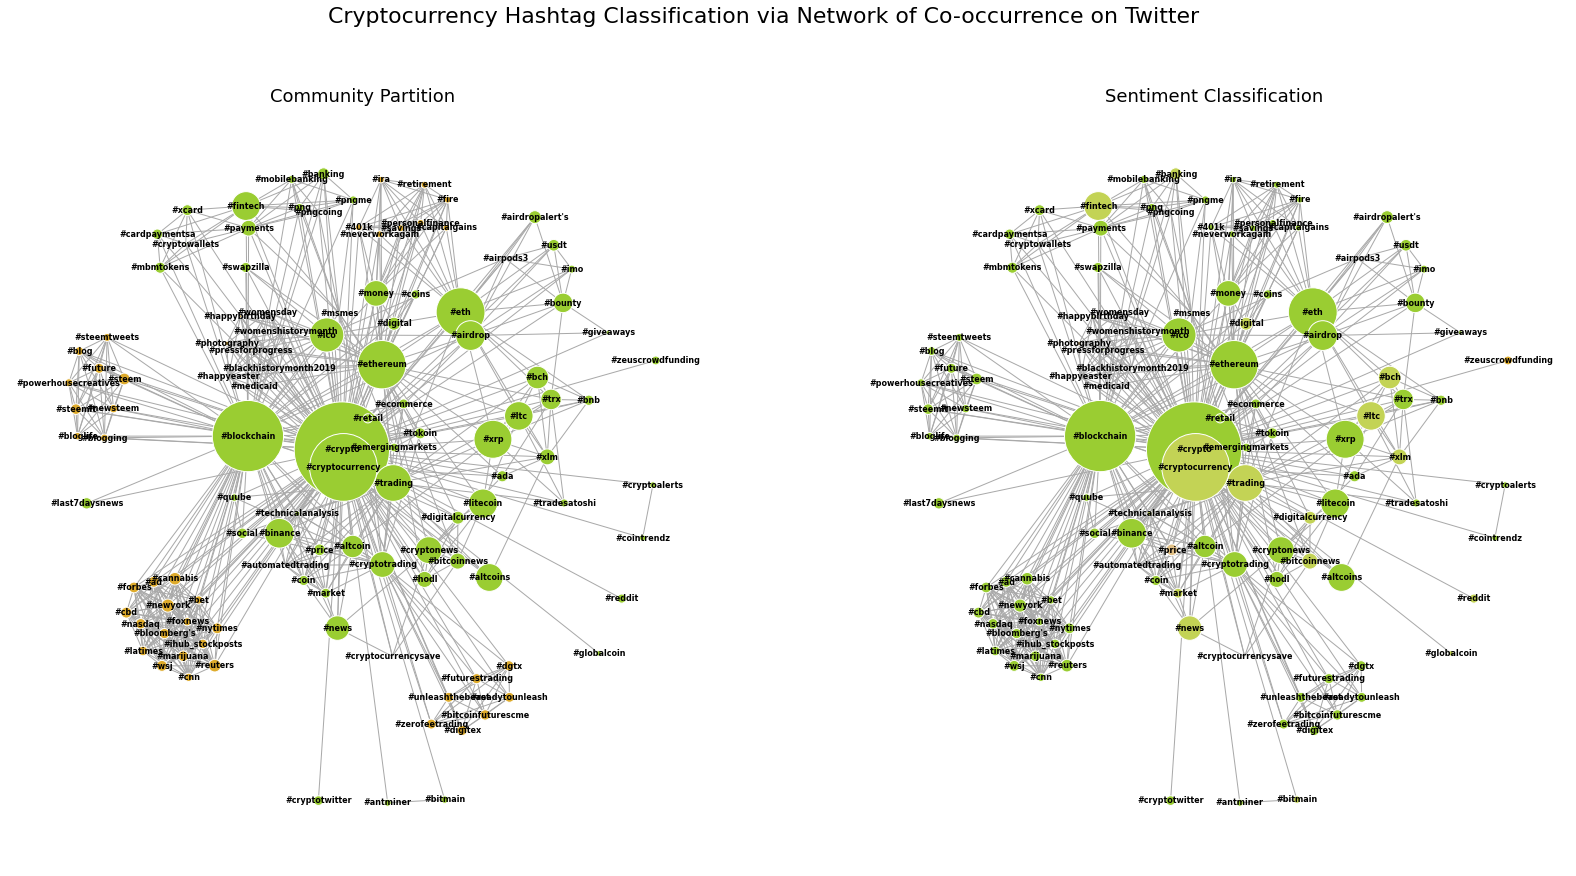

In [ ]:
# Girvan Newman modularity
%time clusters = get_newman_modularity_partitions(sub_g)
fig = plot_subgraph(sub_g, reduce_to_2_communities(clusters,3)[0])
fig.show()

# Predicting Opinion Polarity


### Seasonality Check

### Train Test Split

In [ ]:
# split data into train and test. We will need this later for VAR analysis
def ts_train_test_split(df, train_size):
    return df.iloc[:int(len(df)*train_size),:], df.iloc[int(len(df)*train_size):,:]

ts1 =ts1.sort_values('date')
train, valid =  ts_train_test_split(ts1, 0.7)

### Results, Evaluation, and Performance

In [ ]:
from sklearn.metrics import mean_squared_error

def get_ts_pred_rmse(y_true, y_pred, model_name):
  rmse = mean_squared_error(y_true, 
                            y_pred,
                            squared=False)
  print(f"RMSE for {model_name} on 20% validation set (11/04/2019~11/30/2019): {rmse}")
  return rmse

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from fbprophet import Prophet
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

def compare_model(train, valid):
  FORECAST_TERM = len(valid)
  print("Number of future terms to forecast: ", FORECAST_TERM)

  arma_model = ARIMA(train.perc_btc_favor_tweets, order=(4, 0, 1))
  arma_model_res = arma_model.fit()
  arma_pred = arma_model_res.forecast(FORECAST_TERM, alpha = 0.05) 
  arma_rmse = mean_squared_error(valid.perc_btc_favor_tweets, arma_pred, squared=False)  

  es_fit0 = SimpleExpSmoothing(
      train[['date','perc_btc_favor_tweets']].set_index('date'), 
      initialization_method="estimated"
  ).fit()
  es_fit1 = ExponentialSmoothing(
      train[['date','perc_btc_favor_tweets']].set_index('date'),
      trend="add",
      damped_trend = True,
      initialization_method="estimated",
  ).fit()
  es_fit2 = ExponentialSmoothing(
      train[['date','perc_btc_favor_tweets']].set_index('date'),
      seasonal_periods=7, # 4 for quarterly data or 7 for daily data with a weekly cycle.
      trend="add",
      damped_trend = True,
      seasonal="add",
      initialization_method="estimated",
  ).fit()

  es1_pred = es_fit0.forecast(FORECAST_TERM)
  es1_rmse = mean_squared_error(valid.perc_btc_favor_tweets, es1_pred, squared=False)
  es2_pred = es_fit1.forecast(FORECAST_TERM)
  es2_rmse = mean_squared_error(valid.perc_btc_favor_tweets, es2_pred, squared=False) 
  es3_pred = es_fit2.forecast(FORECAST_TERM)
  es3_rmse = mean_squared_error(valid.perc_btc_favor_tweets, es3_pred, squared=False)

  prophet_train = train[['date','perc_btc_favor_tweets']]
  prophet_train.columns = ['ds','y']
  # Build the model
  prophet_model = Prophet(
      interval_width = 0.95,
      changepoint_prior_scale = 0.9,
      growth = 'linear',
      seasonality_prior_scale = 0.02,
      weekly_seasonality = True,
      daily_seasonality = False,
      yearly_seasonality = False
  )
  prophet_model.add_country_holidays(country_name='US')
  prophet_model.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.01)
  prophet_model.fit(prophet_train)
  future_dt = prophet_model.make_future_dataframe(periods=FORECAST_TERM)
  prophet_pred = prophet_model.predict(future_dt)
  prophet_rmse = mean_squared_error(valid.perc_btc_favor_tweets, prophet_pred.yhat[-FORECAST_TERM:],squared=False)

  model_lst = ['ARMA','Simple EM','Double EM','Triple EM','FB Prophet']
  rmse_lst = [arma_rmse, es1_rmse, es2_rmse, es3_rmse, prophet_rmse]
  df = pd.DataFrame(columns = ['RMSE'],index=model_lst)    
  df['RMSE'] = rmse_lst
  return (df.sort_values(by='RMSE'),list(arma_pred),list(es1_pred),list(es2_pred),list(es3_pred),list(prophet_pred.yhat[-FORECAST_TERM:]))

In [ ]:
import plotly.graph_objects as go
from plotly.graph_objs import *
import plotly.io as pio
pio.templates.default = "none"

In [ ]:

# --------------------------------------------------------------------------------
# Plotly Viz
# --------------------------------------------------------------------------------
def sentiment_ts_plotly_viz(data, pred_date_range, arma_pred, es1_pred, es2_pred, es3_pred, prophet_pred):
    '''
    Input:
        data
        pred_rate_range
        ...
    Output:
        fig2 (Plotly.graph figure object)
    '''        

    x = list(data.date)
    y1_route = list(data["perc_btc_favor_tweets"])

    layout = Layout(
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
    )

    fig2 = go.Figure(layout = layout)

    # add the actual scatter points
    fig2.add_trace(go.Scatter(
        x=x, y=y1_route,
        line_color='#393536',
        mode = 'markers',
        name='Actual Sentiment Percentage',
        showlegend=True,
        hovertemplate =
          '<b>% Crypto Favoring Tweets: </b> %{y}'+
          '<br><b>Date: </b>: %{x|%Y/%m/%d (%a)}<br><extra></extra>',
    ))

    # add ARMA predictions
    fig2.add_trace(go.Scatter(
        x=pred_date_range, y=arma_pred,
        line_color='#113932',
        mode = 'lines+markers',
        name='ARMA',
        showlegend=True,
        hovertemplate =
          '<b>ARMA Predicted: % Crypto Favoring Tweets: </b> %{y}'+
          '<br><b>Date: </b>: %{x|%Y/%m/%d (%a)}<br><extra></extra>',
    ))

    # add SEM predictions
    fig2.add_trace(go.Scatter(
        x=pred_date_range, y=es1_pred,
        line_color='#1f5c39',
        mode = 'lines+markers',
        name='Simple Exponential Smoothing',
        showlegend=True,
        hovertemplate =
          '<b>SEM Predicted: % Crypto Favoring Tweets: </b> %{y}'+
          '<br><b>Date: </b>: %{x|%Y/%m/%d (%a)}<br><extra></extra>',
    ))

    # add Double Exponential Smoothing predictions
    fig2.add_trace(go.Scatter(
        x=pred_date_range, y=es2_pred,
        line_color='#547e2a',
        mode = 'lines+markers',
        name='Double Exponential Smoothing',
        showlegend=True,
        hovertemplate =
          '<b>DEM Predicted: % Crypto Favoring Tweets: </b> %{y}'+
          '<br><b>Date: </b>: %{x|%Y/%m/%d (%a)}<br><extra></extra>',
    ))

    # add Triple Exponential Smoothing predictions
    fig2.add_trace(go.Scatter(
        x=pred_date_range, y=es3_pred,
        line_color='#a09801',
        mode = 'lines+markers',
        name='Triple Exponential Smoothing',
        showlegend=True,
        hovertemplate =
          '<b>TEM Predicted: % Crypto Favoring Tweets: </b> %{y}'+
          '<br><b>Date: </b>: %{x|%Y/%m/%d (%a)}<br><extra></extra>',
    ))

    # add FB Prophet predictions
    fig2.add_trace(go.Scatter(
        x=pred_date_range, y=prophet_pred,
        line_color='#ffa600',
        mode = 'lines+markers',
        name='FB Prophet',
        showlegend=True,
        hovertemplate =
          '<b>FB Prophet Predicted: % Crypto Favoring Tweets: </b> %{y}'+
          '<br><b>Date: </b>: %{x|%Y/%m/%d (%a)}<br><extra></extra>',
    ))

    # Set the layout
    fig2.update_layout(
        font_family="Arial",
        title_font_family="Arial",
        xaxis_title="Date",
        yaxis_title="% Crypto Favoring Tweets",
        xaxis=dict(    
            showline=True,
            showticklabels=True,
            linewidth=2,
            tickfont=dict(
                family='Arial',
                size=16,
                color='rgb(82, 82, 82)',
            ),
            rangeslider = dict(
                visible = True),
            type = "date"
        ),
        yaxis = dict(tickfont = dict(size = 16)),
        hoverlabel=dict(
            bgcolor="white",
            font_size=14,
            font_family="Arial"
        )
    )

    # Title
    annotations = []
    annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                                  xanchor='left', yanchor='bottom',
                                  text=f'Predicting Percentage of Crypto Favoring Tweets in the Next {len(pred_date_range)} Days',
                                  font=dict(family='Arial',
                                            size=26,
                                            color='rgb(37,37,37)'),
                                  showarrow=False))

    fig2.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
    fig2.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
    fig2.update_layout(annotations=annotations)
    return fig2

In [ ]:
train, valid = ts_train_test_split(ts1, 0.87)
rmse_df, arma_pred,es1_pred,es2_pred,es3_pred,prophet_pred = compare_model(train, valid)
rmse_df

Number of future terms to forecast:  14


,RMSE
Double EM,0.029762
Simple EM,0.031296
ARMA,0.031342
FB Prophet,0.034071
Triple EM,0.034400


In [ ]:
sentiment_ts_plotly_viz(ts1, list(valid.date), arma_pred, es1_pred, es2_pred, es3_pred, prophet_pred)

# Appendix
Require careful environment set-up and thus cannot guarantee error-free if running directly

## Collecting Data from Twitter API

In [ ]:
# Download/Update necessary packages to collect tweets
!pip install tweepy --upgrade
!pip install oauth2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Build Connection
The search_all_tweets can only be built upon OAuth2 with BEARER TOKEN    
Academic Twitter Account Portal: https://developer.twitter.com/en/portal/products/academic-research

In [ ]:
import tweepy as tw
import oauth2 as oauth

BEARER_TOKEN = 'AAAAAAAAAAAAAAAAAAAAAKnLcAEAAAAAGYnIkFsqJu4O%2BuIvkx1SPn2htBU%3DYNKxPPDLNr1uIMhjUI071W8Wy2lLDs8e2V2J3XL5Q31GVUNLMc'

def build_connection():
    """ Construct a twitter api instance using your tokens entered above.
    Returns:
      An instance of the twitter API.
    """
    client = tw.Client(BEARER_TOKEN, wait_on_rate_limit=True) 

    if(client):
        print('Established Twitter connection Using OAuth2.')
    return client

# running example
client = build_connection()

Established Twitter connection Using OAuth2.


#### Retrieve the Tweets containing Certain Keyword
- Endplot: Client.search_all_tweets 
> full archive academic search, see [tweepy doc](https://docs.tweepy.org/en/stable/client.html?highlight=search_all#tweepy.Client.search_all_tweets)
- Return: tweepy.Response(data, includes, errors, meta) object
> The Response returned by Client methods is a collections.namedtuple, with data, includes, errors, and meta fields, corresponding with the fields in responses from Twitter’s API. Source: [tweepy doc](https://docs.tweepy.org/en/stable/client.html?highlight=search_all#place-fields-parameter)

**Keywords that I am using for the search (all the collect tweets are supposed to contain the following terms) :** btc, bitcoin, crypto, eth, memecoin (keywords is indifferent for capital letters). See reference [paper1](https://scholar.smu.edu/cgi/viewcontent.cgi?article=1039&context=datasciencereview)


In [ ]:
# Replace with your own search query
query = '(btc OR bitcoin OR crypto OR eth OR memecoin) -is:retweet lang:en' # keyword list is verified in several articles. 
start_time = '2019-01-01T00:00:00Z'
end_time = '2019-12-01T00:00:00Z'

In [ ]:
def get_geo_place_id(tweet):
  try:
    if 'place_id' in tweet.geo.keys():
      return tweet.geo['place_id']
    elif 'coordinates' in tweet.geo.keys():
      return tweet.geo['coordinates']['coordinates']
    else:
      return 'NoGeoInfo'
  except:
    return 'NoGeoInfo'

def tweepy_search_tweets(query, start_time, end_time, max_results):
    tweets = client.search_all_tweets(query=query, 
                                      start_time = start_time,
                                      end_time = end_time,
                                        tweet_fields=['created_at','public_metrics','geo'], 
                                        expansions=['author_id','geo.place_id'], # according to Twitter official doc, only a small portion of tweets is geo-tagged. (https://developer.twitter.com/en/docs/tutorials/building-high-quality-filters)
                                        place_fields = ['place_type','geo'],
                                        max_results=max_results) # max_results – The maximum number of search results to be returned by a request. A number between 10 and the system limit (currently 500)
    if tweets:
      print(f'Retrieved Tweets Response Successfully')
    else:
      print("None Response.")
    return tweets

def write_search_tweets_to_df(tweets, df):
    tweets_data = tweets.data

    tmp1 = pd.DataFrame(columns = ['tweet_id','user_id','text','create_ts','retweet_cnt','reply_cnt','like_cnt','quote_cnt','geo_place_id'])
    
    for i in range(len(tweets.data)):
      tmp1 = tmp1.append(pd.DataFrame([[
                tweets_data[i].id,
                tweets_data[i].author_id,
                tweets_data[i].text,
                tweets_data[i].created_at,            
                tweets_data[i].public_metrics['retweet_count'],
                tweets_data[i].public_metrics['reply_count'],
                tweets_data[i].public_metrics['like_count'],
                tweets_data[i].public_metrics['quote_count'],
                get_geo_place_id(tweets_data[i])]],
              columns = ['tweet_id','user_id','text','create_ts','retweet_cnt','reply_cnt','like_cnt','quote_cnt','geo_place_id']),
              sort = True,
              ignore_index = True)

    df = pd.concat([df, tmp1], axis = 0, ignore_index = True, sort = True) 

    if len(df)>df.tweet_id.nunique():
      print("Duplicates detected.")
      df = df.drop_duplicates()
    else:
      print("---------- Response Info ------------------")
      print(f"Number of tweets: {len(tmp1)};\nResponse Time Range: [{tmp1.create_ts.min()}, {tmp1.create_ts.max()}];")
      print("------------ Complete ---------------------")
    return df


In [ ]:
# df = pd.DataFrame(columns = ['tweet_id','user_id','text','create_ts','retweet_cnt','reply_cnt','like_cnt','quote_cnt','geo_place_id'])
tweets = tweepy_search_tweets(query, start_time, end_time, 10)

In [ ]:
# The iterative code to retrieve the tweets by calling the Twitter official API
# Commnented for code-simplification concern

# i = 0
# while True:
#   try:
#     i+=1
#     print(f"========= {i}th Request ==================")
#     end_time = df.create_ts.min()
#     tweets = tweepy_search_tweets(query, start_time, end_time, 500)
#     df = write_search_tweets_to_df(tweets,df)
#     print(f"df now has {len(df)} rows \n")
#     print(f"==========================================")
#     if i == 2500:
#       print("Reach 2500th. Export File")
#       df.to_csv("crypto_tweets_20190901_20191130")
#       break    
#   except Exception as e:
#       print("Error Captured:", e)
#       time.sleep(10)
#       break

## Sentiment Classification

##### **Light Pre-Processing**     
Before tokenizing our text, we will perform some **slight processing** on our text including removing entity mentions (eg. @united) and some special character. The level of processing here is much less than in previous approachs because BERT was trained with the entire sentences

In [ ]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Remove Links
    text = re.sub(r'http\S+', '', text)                                

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
# Light Preprocessing for BERT (~2 min 10s for 13 million tweets)
df['clean_text'] = list(map(lambda x:text_preprocessing(x), df.text))

##### **Sentiment Classification**

###### Lexicon-based Approach to Extract Sentiments: **VADER**   
*VADER doesn't require pre-processing work, it handles emojis, slangs, emoticons pretty well*
> The Compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive).             
- positive sentiment : (compound score >= 0.05) 
- neutral sentiment : (compound score > -0.05) and (compound score < 0.05) 
- negative sentiment : (compound score <= -0.05)        
Source: https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f; https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/

In [ ]:
!pip install vaderSentiment

     |████████████████████████████████| 125 kB 4.2 MB/s 


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
 
# function to print sentiments
# of the sentence.
def get_vader_sentiment(sentence):
 
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
    sentiment_score = sentiment_dict['compound']

    # sentimen classification
    if sentiment_dict['compound'] >= 0.05 :
        sentiment_type = 'positive'
    elif sentiment_dict['compound'] <= - 0.05 :
        sentiment_type = 'negative'
    else :
        sentiment_type = 'neutral'
    return sentiment_type, sentiment_score

In [ ]:
# Retrieve sentiment classification
# takes ~2 mins 10s to run for every 10,000 tweets 

df.iloc[800000:1000000,[15,16]] = list(map(lambda txt:get_vader_sentiment(txt), df.iloc[800000:1000000,14])) # common method

###### Predicting Sentiment Labels using supervised ML-based approach: **BERT**(To be revised)  
> BERT stands for **Bidirectional Encoder Representations from Transformers** and it is a state-of-the-art machine learning model used for NLP tasks. **Jacob Devlin and his colleagues** developed BERT at **Google in 2018**. Devlin and his colleagues trained the BERT on English Wikipedia (2,500M words) and BooksCorpus (800M words) and achieved the best accuracies for some of the NLP tasks in 2018. There are two pre-trained general BERT variations: The base model is a **12-layer, 768-hidden, 12-heads, 110M parameter** neural network architecture, whereas the large model is a 24-layer, 1024-hidden, 16-heads, 340M parameter neural network architecture. Figure 2 shows the visualization of the BERT network created by Devlin et al.

In this notebook I'll use the **HuggingFace's** transformers library to **fine-tune pretrained BERT model.**

Source: http://mccormickml.com/2019/07/22/BERT-fine-tuning/, https://skimai.com/fine-tuning-bert-for-sentiment-analysis/, https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-bert-and-hugging-face-294e8a04b671 



In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:
!pip install transformers

     |████████████████████████████████| 4.2 MB 4.2 MB/s 
     |████████████████████████████████| 84 kB 3.3 MB/s 
     |████████████████████████████████| 596 kB 63.5 MB/s 
     |████████████████████████████████| 6.6 MB 32.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


**Step 1: BERT Tokenizer**
1. Load the tokenizer
2. Get the maximum length
3. Encode the texts using tokenizer

    
In order to apply the pre-trained BERT, we must use the tokenizer provided by the library. This is because (1) the model has a specific, fixed vocabulary and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary words.

In addition, we are required to add special tokens to the **start and end** of each sentence, **pad & truncate** all sentences to a **single constant length (max sentence length <= 512 tokens)**, and explicitly specify what are padding tokens with the "attention mask".

The `tokenizer.encode_plus` method of BERT tokenizer will:

1. split our text into tokens,
2. add the special `[CLS]`(always the **first** token) and `[SEP]`(always the **last** token) tokens, and
3. convert these tokens into indexes(**Token IDs**) of the tokenizer vocabulary,
4. pad or truncate sentences to max length, and
5. create attention mask (**Padding**).
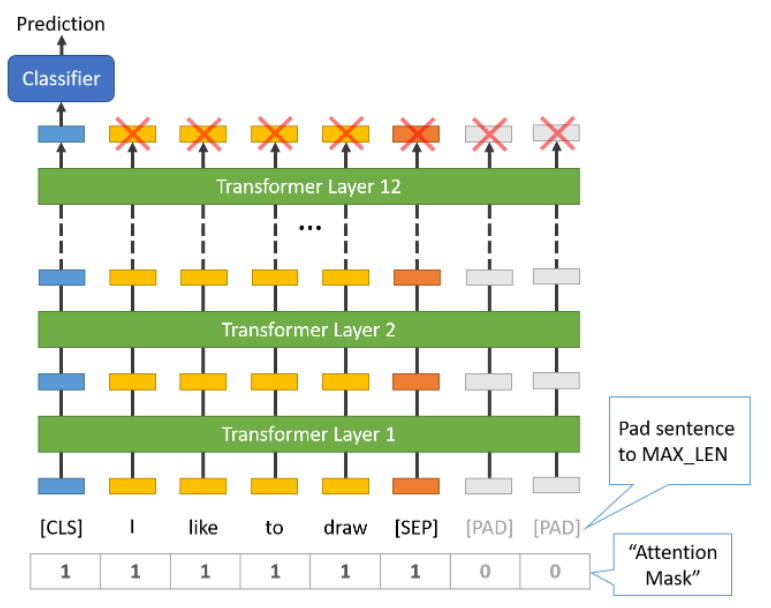
> http://mccormickml.com/2019/07/22/BERT-fine-tuning/

In [ ]:
# Load the BERT tokenizer.

from transformers import BertTokenizer
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
max_len = 256

In [ ]:
# Decide on the maximum sentence length (800,000 rows take ~11 min)
max_len = 0

# For every sentence...
for txt in df.clean_text:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(txt, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

In [ ]:
df_copy = df.copy()
df = df.sample(100000,random_state = 123).reset_index(drop =True)

In [ ]:
# Tokenize all of the tweets and map the tokens to thier word IDs. (100,000 rows take ~14 min)
def get_token_encode_result(df, max_len):
  input_ids = []
  attention_masks = []
  tweets = df.clean_text.values
  labels = list(map(lambda x:1 if x=='positive' else 0, df.sentiment_type))

  # For every tweets...
  for txt in tweets:
      # `encode_plus` will:
      #   (1) Tokenize the tweets.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the tweets to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          txt,                      # tweets to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = max_len,           # Pad & truncate all tweets.
                          pad_to_max_length = True,
                          truncation=True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )
      
      # Add the encoded tweets to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  return input_ids, attention_masks, labels


input_ids, attention_masks, labels = get_token_encode_result(df, max_len)

**Step 2: Train Test Split and Create DataLoader**      

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-20 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

80,000 training samples
20,000 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

**Step 3: Set up the pre-trained BERT**      
1. Load the pre-trained BERT
2. Define the **optimizer** (usually adam)
3. Define the **Learning Rate Scheduler**
> For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the BERT paper):
  - Batch size: 16, 32    
  - Learning rate (Adam): 5e-5, 3e-5, 2e-5   
  - Number of epochs: 2, 3, 4

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
import time
import datetime

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

**Step 4:** Run to fine-Tune to BERT model

In [ ]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 200 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss, logits = output['loss'], output['logits'] # the output is a aggregate instance and we need to call the key to access loss and logits. 

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            output = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss, logits = output['loss'], output['logits'] # the output is a aggregate instance and we need to call the key to access loss and logits.  
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch   200  of  2,500.    Elapsed: 0:04:14.
  Batch   400  of  2,500.    Elapsed: 0:08:44.
  Batch   600  of  2,500.    Elapsed: 0:13:14.
  Batch   800  of  2,500.    Elapsed: 0:17:44.
  Batch 1,000  of  2,500.    Elapsed: 0:22:14.
  Batch 1,200  of  2,500.    Elapsed: 0:26:45.
  Batch 1,400  of  2,500.    Elapsed: 0:31:15.
  Batch 1,600  of  2,500.    Elapsed: 0:35:45.
  Batch 1,800  of  2,500.    Elapsed: 0:40:15.
  Batch 2,000  of  2,500.    Elapsed: 0:44:45.
  Batch 2,200  of  2,500.    Elapsed: 0:49:15.
  Batch 2,400  of  2,500.    Elapsed: 0:53:45.

  Average training loss: 0.21
  Training epcoh took: 0:56:00

Running Validation...
  Accuracy: 0.95
  Validation Loss: 0.14
  Validation took: 0:05:23

======== Epoch 2 / 2 ========
Training...
  Batch   200  of  2,500.    Elapsed: 0:04:30.
  Batch   400  of  2,500.    Elapsed: 0:09:00.
  Batch   600  of  2,500.    Elapsed: 0:13:30.
  Batch   800  of  2,500.    Elapsed: 0:18:00.
  Batch 1

**Step 5: Performance Evaluation on Validation Dataset**

In [ ]:
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, roc_curve, auc,classification_report

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)['logits']
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

def evaluate_roc(train_true, train_pred, valid_true, valid_pred):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    """
    # Make predictions
    train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
    valid_fpr, valid_tpr, _ = roc_curve(valid_true, valid_pred)
    train_auc = np.round(auc(train_fpr, train_tpr), 3)
    valid_auc = np.round(auc(valid_fpr, valid_tpr), 3)

    print(f'Train AUC: {train_auc:.4f}')
    print(f'Validation AUC: {valid_auc:.4f}')
       
    # Get accuracy over the test set
    valid_pred = np.where(valid_pred >= 0.5, 1, 0)
    valid_accuracy = accuracy_score(valid_true, valid_pred)
    print(f'Validation Accuracy: {valid_accuracy*100:.2f}%')

    train_pred = np.where(train_pred >= 0.5, 1, 0)
    train_accuracy = accuracy_score(train_true, train_pred)
    print(f'traination Accuracy: {train_accuracy*100:.2f}%')
    
    # Plot ROC AUC
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
    ax.plot(valid_fpr, valid_tpr, label='Test AUC: ' + str(valid_auc))
    ax.plot([0, 1], [0, 1], ls="--", c=".3")
    ax.set_xlabel('False Positive Rate', fontsize=14)
    ax.set_ylabel('True Positive Rate', fontsize=14)
    ax.legend(fontsize=14)
    plt.show()

  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output[0], dim=1)

  return int(prediction)

def get_ylabels_from_torch(dataloader):
    y_val = []
    for batch in dataloader:
        y_val.append(list(batch[2].to(device).to('cpu').numpy()))
    return sum(y_val,[])

In [ ]:
# Compute predicted probabilities on the test set 
val_probs = bert_predict(model, validation_dataloader)
train_probs = bert_predict(model, train_dataloader)


Train AUC: 0.4990
Validation AUC: 0.9930
Validation Accuracy: 96.09%
traination Accuracy: 50.54%


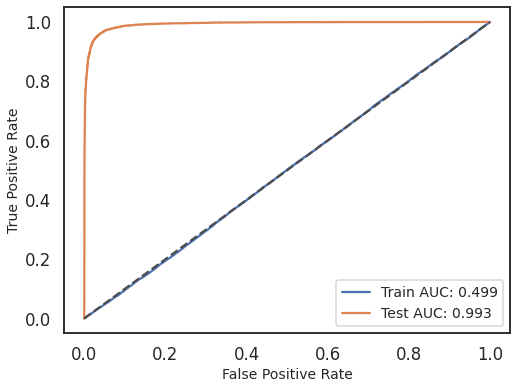

In [ ]:
# Evaluate the Bert classifier
valid_true = get_ylabels_from_torch(validation_dataloader)
train_true = get_ylabels_from_torch(train_dataloader)

train_pred = []
for i in train_probs:
  train_pred.append(i[1])
train_pred = np.array(train_pred)

valid_pred = []
for i in val_probs:
  valid_pred.append(i[1])
valid_pred = np.array(valid_pred)

evaluate_roc(train_true, train_pred, valid_true, valid_pred)

In [ ]:
# Get classification report
print(classification_report(y_true=valid_true, y_pred=(valid_pred > 0.5).astype(int),
                            target_names = ["negative:0","positive:1"]))

              precision    recall  f1-score   support

  negative:0       0.97      0.96      0.96     10944
  positive:1       0.96      0.96      0.96      9056

    accuracy                           0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.96      0.96      0.96     20000



In [ ]:
# It has been tested that: loading the model and making the prediction again generates the same results.
torch.save(model, '/content/drive/MyDrive/Research: Changing Opinions towards Cryptocurrency under Rising Cost of Living/Model/bert_10w_tweets.pt')

# model2 = torch.load('/content/drive/MyDrive/Research: Changing Opinions towards Cryptocurrency under Rising Cost of Living/Model/bert_10w_tweets.pt')

# val_probs2 = bert_predict(model2, validation_dataloader)
# a = pd.DataFrame()
# a['prob1']=list(val_probs)
# a['prob2']=list(val_probs2)

**Step 6: Predict the sentiment labels and add to the dataset**

In [ ]:
# The model is trained on 80,000 tweets (training set = 80%) and evaluated on 20,000 tweets (validation set = 20%)
# Pre-requisite to make predictions: (1) load the model (2) load the BERT tokenizer
max_len = 256
model = torch.load('/content/drive/MyDrive/Research: Changing Opinions towards Cryptocurrency under Rising Cost of Living/bert_10w_tweets.pt')

In [ ]:
from transformers import BertTokenizer
import torch.nn.functional as F 
def predictionPipeline(text, model=model, tokenizer = tokenizer, MAX_LEN=max_len):
  """
  Reference:
  1. The main body of this function: https://stackoverflow.com/questions/69820318/predicting-sentiment-of-raw-text-using-trained-bert-model-hugging-face
  2. Transform binary predictions into logits 
  """
  model.aux_logits=False
  encoded_review = tokenizer.encode_plus(
      text,
      max_length=MAX_LEN,
      add_special_tokens=True,
      return_token_type_ids=False,
      truncation=True,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  output = model(input_ids, attention_mask)
  logits = output[0]
  return float(F.softmax(torch.tensor(logits.detach().cpu().numpy()))[0][1]) # softmax returns a tensor list of probabilities of clashahhas 0 and class 1, here we only returns the class 1 prob 



In [ ]:
# 30 min for 100,000 rows
%time df.loc[300000:500000,'bert_sentiment_prob']=df.loc[300000:500000,'clean_text'].apply(predictionPipeline)


CPU times: user 48min 57s, sys: 7.69 s, total: 49min 4s
Wall time: 48min 54s


In [ ]:
# check how they match: as expected...
df['is_same'] = list(map(lambda x,y:1 if round(x,0)==round(y,0) else 0, df.is_btc_favor_tweets,df.bert_sentiment_prob))
print("Accuracy:", df.is_same.mean())
# check the records
df.loc[df.is_same == 0, ['bert_sentiment_prob','is_btc_favor_tweets','sentiment_type','clean_text','is_same']]